In [2]:
%matplotlib widget
import json
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import re
import requests
import seaborn as sns
import sys

from ast import literal_eval
from BCBio import GFF
from diskcache import Cache
from itertools import product, groupby
from matplotlib.patches import Polygon
from pathlib import Path
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, accuracy_score

from Scripts.heatmap import plot_heatmap, get_mut_idxs
from Scripts.go_api import get_ora, get_gsea


cache = Cache(".cache/")
# get_ora = cache.memoize()(get_ora)

sns.set_theme(
    "paper", 
    rc={
        'font.size': 7,
        'axes.labelsize': 7,
        'axes.titlesize': 7,
        'xtick.labelsize': 6,
        'ytick.labelsize': 6,
        'legend.fontsize': 6,
        'legend.title_fontsize': 7,
        'figure.figsize': (6.3, 3),
        'svg.fonttype': 'none'
        # 'axes.labelpad': 2.0,
        # 'xtick.major.pad': -3.0,
        # 'ytick.major.pad': -3.0
    }
)
other_cmap = sns.light_palette("gray", reverse=False, as_cmap=True)

with open("config.json") as fh:
    config = json.load(fh)

def savefig(fig, name, **kwargs):
    p = Path("Output/Figures/")
    p.mkdir(exist_ok=True, parents=True)
    for fmt in ("png", "svg"):
        fig.savefig(p / f"{name}.{fmt}", bbox_inches=None, dpi=300, **kwargs)

def separate(data, col, into, sep="_", **kwargs):
    return data.assign(
        **data.get(col).str.split(sep, expand=True)
        .rename(columns={i: x for i, x in enumerate(into)})
    )
        
def add_barplot_values(fig, **kwargs):
    opts = dict(rotation=90, padding=5, label_type='edge')
    opts.update(kwargs)
    axes = fig.axes if not hasattr(fig.axes, "flatten") else fig.axes.flatten()
    for ax in axes:
        for c in ax.containers:
            color = c.patches[0].get_facecolor()
            annot = ax.bar_label(c, color=color, **opts)
    return fig


def set_box_aspect(fig, aspect=1.0, **opts):
    axes = fig.axes if isinstance(fig.axes, list) else fig.axes.flatten()
    for ax in axes:
        ax.set_box_aspect(aspect)
    return fig
       
    
def get_regulation(row, lfc_th=1, p_th=0.05):
    p_val = row.iloc[0]
    lfc_val = row.iloc[1]
    if (p_val < p_th) and (lfc_val > lfc_th):
        return "Up"
    elif (p_val < p_th) and (lfc_val < -lfc_th):
        return "Down"
    else:
        return "None"

def merge_gene_labels(row, col1="gene_name", col2="gene_id"):
    if row.loc[col1] == row.loc[col2]:
        return row.loc[col2]
    else:
        return f"{row.loc[col1]} ({row.loc[col2]})"

def flatten_columns(data, sep="-"):
    data.columns = data.columns.map(sep.join).str.strip(sep)
    return data

def separate_legends(axes, sep_index=3, loc="center", bbox_to_anchor=None, ysep=0.2, **kwargs):
    bbox_to_anchor = bbox_to_anchor or (1.3, 0.5)
    lines, handles = axes.get_legend_handles_labels()
    axes.add_artist(
        axes.legend(
            lines[:sep_index], 
            handles[:sep_index], 
            loc=loc, 
            bbox_to_anchor=(bbox_to_anchor[0], bbox_to_anchor[1]+ysep),
            **kwargs
        )
    )
    axes.add_artist(
        axes.legend(
            lines[sep_index:], 
            handles[sep_index:], 
            loc=loc, 
            bbox_to_anchor=(bbox_to_anchor[0], bbox_to_anchor[1]-ysep),
            **kwargs
        )
    )

Metadata:

In [4]:
df_uniprot = (
    pd.read_csv("Data/uniprot_mapping.csv")
    .drop(columns=["reviewed", "organism", "length"])
)

strains_mic = config['new_strain_labels'] | {"403.2": "$7_B$", "446.1": "$8_A$"}
df_mic = (
    pd.read_excel(
        "Data/Samples/overview_analysed_samples.xlsx", 
        sheet_name="overview_simplified", 
        dtype={"strain": str}
    )
    .query("strain in @strains_mic.keys()")
    .replace({"strain": strains_mic})
    .query("~(strain == '$2_C$' and condition == 'M')")
)

Mutations (with additonal annotations from eggnog-mapper):

In [6]:
def get_alt_names(pos, record):
    alt_names = [
        name
        for rec in record
        for x in rec.features 
        if x.location.start < pos < x.location.end and "em_Preferred_name" in x.qualifiers
        for name in x.qualifiers["em_Preferred_name"] 
        if name != "true"
    ]
    if alt_names: # To not return an empty list
        return alt_names

    
def get_alt_names_strain(strain, positions):
    p = Path(f"Data/EggnogMapper/{strain}_P/out.emapper.decorated.gff")
    if p.exists():
        with open(p) as fh:
            rec = [x for x in GFF.parse(fh)]

        return [get_alt_names(pos, rec) for pos in positions]
    else:
        return [None]*len(positions)


df_cross_mut = (
    pd.concat(
        [
            pd.read_csv(f"Output/Snippy/{strain}_{cond}_vs_{ref_strain}_P/snps.csv")
            .assign(strain=strain, condition=cond, ref_strain=ref_strain)
            for strain, cond, ref_strain in product(config["snippy"], ["M", "C", "P"], config["snippy"])
        ]
    )
    .reset_index(drop=True)
    .replace({
        "strain": config["new_strain_labels"], 
        "ref_strain": config["new_strain_labels"], 
        "condition": {"M": "MEM", "C": "CZA", "P": "PAR"}
    })
    .query("~(strain == '$2_C$' and condition == 'MEM')")
)
    
rev_labels = {v: k for k, v in config["new_strain_labels"].items()}

df_mut2 = (
    pd.concat([
        df_strain.assign(alt_names=get_alt_names_strain(rev_labels[strain], df_strain.POS))
        for strain, df_strain 
        in df_cross_mut.query("strain == ref_strain").groupby("strain")
    ])
    .explode("alt_names")
    .assign(gene_name=lambda x: x.GENE.fillna(x.alt_names))
    .rename(columns=lambda x: x.lower())
    .merge(df_uniprot.drop_duplicates(subset="gene_name"), on="gene_name", how="left")
    .assign(
        synonymous=lambda x: 
        x.effect.str.contains("synonymous_variant").fillna(False).astype(int)
    )
)

LFC for transcriptomics and proteomics:

In [7]:
df_t_lfc = (
    pd.read_csv("Output/DESeq2/dds_results.csv", dtype={"strain": str})
    .merge(df_uniprot, on="gene_id", how="left")
    .query("strain in @config['selected_strains']")
    .assign(
        strain=lambda x: x.strain.replace(config["new_strain_labels"]),
        comparison=lambda x: x.comparison.replace(config["new_comparison_labels"]),
        log_padj=lambda x: -np.log10(x.padj),
        regulation=lambda x: x.get(["padj", "log2fc"]).apply(get_regulation, axis=1)
    )
)

df_p_lfc = (
    pd.read_csv("Output/Proteomics/lfc.csv", dtype={"strain": str})
    .dropna(subset=["log2fc", "padj", "prot_id"])
    .merge(df_uniprot, on="prot_id", how="left")
    .query("strain in @config['selected_strains']")
    .assign(
        strain=lambda x: x.strain.replace(config["new_strain_labels"]),
        comparison=lambda x: x.comparison.replace(config["new_comparison_labels"]),
        regulation=lambda x: x.get(["padj", "log2fc"]).apply(get_regulation, axis=1),
        log_padj=lambda x: -np.log10(x["padj"]),
        gene_id=lambda x: x.gene_id.fillna(x.prot_id)
    )
)

cols = ["strain", "gene_id", "prot_id", "gene_name", "prot_name", "comparison", "protein_names"]
df_lfc = (
    pd.merge(df_t_lfc, df_p_lfc, how="outer", on=cols, suffixes=["_t", "_p"])
    .drop_duplicates(["gene_id", "gene_name", "strain", "comparison"])
)

df_lfc_long = pd.concat([
    df_t_lfc.assign(omics="t"), df_p_lfc.assign(omics="p")
])

Normalised transcripomics counts and normalised protein abundance:

In [8]:
def get_replicate2_col(data):
    return (
        data
        .groupby(["strain", "condition"])
        .apply(lambda y: ["A", "B", "C"])
        .explode()
        .reset_index(name="replicate2")
        .replicate2
    )

df_t = (
    pd.read_csv("Output/DESeq2/counts_normalised.csv", index_col=0)
    # pd.read_csv("Output/DESeq2/rlog.csv", index_col=0)  # also leads to separation
    .transpose()
    .reset_index()
    .rename(columns={"index": "isolate"})
    .pipe(separate, "isolate", ["strain", "condition", "replicate"], sep="_", expand=True)
    .replace(config["new_strain_labels"])
    .assign(replicate2=get_replicate2_col)
    .merge(
        df_mic.get(["cza_mic", "mem_mic", "strain", "condition"]),
        on=["condition", "strain"],
        how="left"
    )
)

df_p = (
    pd.read_csv("Output/Proteomics/normalised.csv")
    .query("~protein_name.str.contains('ENSEMBL|CON__')")
    .assign(
        prot_id=lambda x: x.protein_name.str.extract(".*\|(.*)\|.*")
    )
    .dropna(subset="prot_id")
    .set_index("prot_id")
    .drop(columns="protein_name")
    .transpose()
    .reset_index(names="isolate")
    .pipe(separate, "isolate", ["strain", "condition", "replicate"], sep="_", expand=True)
    .query("strain in @config['selected_strains']")
    .replace({"strain": config["new_strain_labels"]})
    .dropna(axis=1)
    .assign(replicate2=get_replicate2_col)
    .merge(
        df_mic.get(["cza_mic", "mem_mic", "strain", "condition"]),
        on=["condition", "strain"],
        how="left"
    )
)

df_t_long = (
    df_t
    .drop(columns=["cza_mic", "mem_mic", "isolate", "replicate"])
    .melt(id_vars=["strain", "condition", "replicate2"], var_name="gene_id")
    .merge(df_uniprot, how="left", on="gene_id")
    .merge(
        df_mic.get(["cza_mic", "mem_mic", "strain", "condition"]),
        on=["condition", "strain"],
        how="left"
    )
    .assign(
        cza_mic_level=lambda x: (x.cza_mic>30).astype(int),
        mem_mic_level=lambda x: (x.mem_mic>30).astype(int)
    )
    .replace({
        "cza_mic_level": {0: "low", 1: "high"}, 
        "mem_mic_level": {0: "low", 1: "high"},
        "condition": {"C": "CZA", "M": "MEM", "P": "PAR"}
    })
    .assign(gene_labels=lambda x: x.apply(merge_gene_labels, axis=1))
)

df_p_long = (
    df_p
    .drop(columns=["cza_mic", "mem_mic", "isolate", "replicate"])
    .melt(id_vars=["strain", "condition", "replicate2"], var_name="prot_id")
    .merge(df_uniprot, how="left", on="prot_id")
    .merge(
        df_mic.get(["cza_mic", "mem_mic", "strain", "condition"]),
        on=["condition", "strain"],
        how="left"
    )
    .assign(
        cza_mic_level=lambda x: (x.cza_mic>30).astype(int),
        mem_mic_level=lambda x: (x.mem_mic>30).astype(int)
    )
    .replace({
        "cza_mic_level": {0: "low", 1: "high"}, 
        "mem_mic_level": {0: "low", 1: "high"},
        "condition": {"C": "CZA", "M": "MEM", "P": "PAR"}
    })
    .assign(gene_labels=lambda x: x.apply(merge_gene_labels, axis=1))
)

In [9]:
def get_pvalues(data, mic):
    mic_col = f"{mic.lower()}_mic_level"
    if len(data.get(mic_col).unique()) > 1:
        return (
            data
            .pivot_table(index="gene_id", columns=mic_col, values="value", aggfunc=list)
            .assign(
                pvalue=lambda x: stats.mannwhitneyu(x.high.tolist(), x.low.tolist(), method="exact", axis=1)[1],
                padj=lambda x: stats.false_discovery_control(x.pvalue),
                high_mean=lambda x: x.high.apply(np.mean),
                low_mean=lambda x: x.low.apply(np.mean),
                fold_change=lambda x: x.high_mean / x.low_mean
            )
            .reset_index()
            .drop(columns=["high", "low", "high_mean", "low_mean"])
        )
    else:
        return pd.DataFrame(columns=["gene_id", "pvalue", "padj", "fold_change"])

def get_all_pvalues(data):
    return pd.concat([
        data.query("condition == 'CZA'").pipe(get_pvalues, "CZA").assign(condition="CZA", mic="CZA"),
        data.query("condition == 'MEM'").pipe(get_pvalues, "CZA").assign(condition="MEM", mic="CZA"),
        data.pipe(get_pvalues, "CZA").assign(condition="All", mic="CZA"),
        data.query("condition == 'CZA'").pipe(get_pvalues, "MEM").assign(condition="CZA", mic="MEM"),
        data.query("condition == 'MEM'").pipe(get_pvalues, "MEM").assign(condition="MEM", mic="MEM"),
        data.pipe(get_pvalues, "MEM").assign(condition="All", mic="MEM"),
    ], ignore_index=True)

df_both_w_pvals = pd.concat([
    get_all_pvalues(df_t_long).assign(omics="T"),
    get_all_pvalues(df_p_long).assign(omics="P")
])

/tmp/ipykernel_9751/97316606.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/tmp/ipykernel_9751/97316606.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([


Eggnog results:

In [11]:
df_ensembl = pd.read_csv("Data/annotation.tsv", sep="\t")

df_eggnog = (
    pd.read_csv("Data/EggnogMapper/PAO1/out.emapper.annotations", skiprows=4, sep="\t")
    .rename(columns={"#query": "query"})
    .query("~query.str.startswith('##')")
)

df_genes_vs_go_terms = (
    df_eggnog
    .merge(df_ensembl, how="left", left_on="query", right_on="transcript_stable_id")
    .assign(go_terms = lambda x: x.GOs.str.split(","))
    .explode("go_terms")
    .pivot(index="gene_stable_id", columns="go_terms", values="go_terms")
    .drop(columns="-")
    .notna()
)

In [13]:
def normalise_by_blank(data):
    blank_row = (
        data
        .query("conc == 'MHB-Blank'")
        .get(["repl1", "repl2", "repl3", "repl4"])
    )
    m = f"There needs to be only one row with 'MHB-Blank' in conc col: {blank_row.shape[0]}"
    assert blank_row.shape[0] == 1, m
    
    blank_mean = blank_row.iloc[0].mean()
    
    return data.assign(
        norm_repl1=lambda x: x.repl1 - blank_mean,
        norm_repl2=lambda x: x.repl2 - blank_mean,
        norm_repl3=lambda x: x.repl3 - blank_mean,
        norm_repl4=lambda x: x.repl4 - blank_mean,
    )

df_transposon = (
    pd.concat([
        pd.read_excel("Data/FollowUpExp/ko_mutants.xlsx", sheet_name="data - previous set")
        .pipe(separate, "mutant", ("mutant", "gene_name"), "/")
        .merge(df_uniprot.get(["gene_id", "gene_name"]), on="gene_name", how="left")
        .assign(exp_round=1, gene_id=lambda x: x.gene_id.fillna("WT")),
        
        pd.read_excel("Data/FollowUpExp/ko_mutants.xlsx", sheet_name="data - OD 0.0005")
        .pipe(separate, "mutant", ("mutant", "gene_id"), "/")
        .merge(df_uniprot.get(["gene_id", "gene_name"]), on="gene_id", how="left")
        .assign(exp_round=2)
    ])
    .groupby(["mutant", "mic", "gene_name", "gene_id"])
    .apply(normalise_by_blank)
    .assign(log2_conc=lambda x: x.conc.apply(lambda y: np.log2(y) if not isinstance(y, str) else y))
    .reset_index(drop=True)
)

# Figure 1

## MIC over time

In [14]:
def get_num_resistant(data, threshold=8):
    total_strains = len(data.Strain.unique())
    return (
        data
        .groupby(["Condition", "MIC", "Days"])
        .MIC_value
        .apply(lambda x: sum(x > threshold))
        .reset_index(name="num_resistant")
        .assign(percent_resistant=lambda x: x.num_resistant*100/total_strains)
    )

def plot_all_mic(data, figsize=None, yticks=None, ylim=None):
    # data = data.assign(log2_mic=lambda x: np.log2(x.MIC_value))
    yticks = yticks or 2.0**np.arange(-6, 9, 2)
    ylim = ylim or (2**(-5), 2**9)
        
    figsize = figsize or (6.3, 2)
    fig, (ax_cza, ax_mem, ax_res) = plt.subplots(1, 3, figsize=figsize)

    sns.lineplot(
        data.pipe(get_num_resistant, threshold=8), 
        x="Days", 
        y="percent_resistant", 
        style="Condition", 
        hue="MIC", 
        markers=True,
        ax=ax_res
    )
    ax_res.set(
        xticks=[0, 5, 10, 15], 
        title=f"Percentage resistant (MIC > 8)", 
        ylabel="Percent", 
        ylim=(-5, 105)
    )

    plot_opts = dict(
        x="Days",
        y="MIC_value",
        hue="MIC",
        hue_order=["CZA", "MEM"],
        native_scale=True,
        dodge=True,
        legend=False,
    )
    for cond, ax in zip(["CZA", "MEM"], [ax_cza, ax_mem]):
        sns.boxplot(
            data.query("Condition == @cond"),
            width=0.5,
            fliersize=0,
            ax=ax,
            **plot_opts
        )

        sns.stripplot(
            data.query("Condition == @cond"),
            edgecolor="black",
            linewidth=0.5,
            size=2,
            ax=ax,
            **plot_opts
        )

        ax.set_yscale('log', base=2)
        ax.axhline(y=8, ls=":", c="gray")

        ax.set(
            title=cond + " cultured", 
            yticks=yticks, 
            yticklabels=yticks
        )
        ax.set_ylabel("MIC value [mg/L]", labelpad=-10)

    ax_cza.set(title="CZA cultured")    
    ax_mem.set(title="MEM cultured",)  #, ylabel="MIC value [mg/L]")

    fig.subplots_adjust(left=0.08, right=0.87, bottom=0.2, wspace=0.3)
    for ax in ax_cza, ax_mem, ax_res:
        ax.set_xticks(data.Days.unique(),)
        ax.tick_params(pad=-2)
        ax.set_box_aspect(1.0)

    separate_legends(ax_res)
    return fig

df_mic_time = (
    pd.read_excel("Data/Samples/mic_time.xlsx")
    .melt(
        id_vars=["MIC", "Condition", "Days"], 
        var_name="Strain", 
        value_name="MIC_value"
    )
    .assign(ParentStrain=lambda x: x.Strain.str.extract("(.*)\."))
    # .query("~(ParentStrain == '090' and Condition == 'MEM')")
)

In [15]:
strain = {"083": 1, "090": 2, "095": 3, "678": 4, "804": 5, "816": 6, "403": 7, "446": 8}
isolate = {"1": "A", "2": "B", "3": "C"}
new_par_labels = {x: str(i+1) for i, x in enumerate(strain)}
new_labels = {
    f"{s_old}.{i_old}": f"${s_new}_{i_new}$" 
    for (s_old, s_new), (i_old, i_new) 
    in product(strain.items(), isolate.items())
}

df_mic_time2 = (
    df_mic_time
    .replace({
        "Strain": new_labels,
        "ParentStrain": new_par_labels
    })
)

Values on lines 42-44 and 133-137 in the paper:

In [16]:
df_mic_time.pipe(get_num_resistant).query("Days==18")

,Condition,MIC,Days,num_resistant,percent_resistant
3,CZA,CZA,18,5,20.833333
7,CZA,MEM,18,9,37.500000
11,MEM,CZA,18,4,16.666667
15,MEM,MEM,18,20,83.333333


Values on line 141 in the paper:

In [17]:
(
    df_mic_time
    .assign(Days=lambda x: "mic_value_day_" + x.Days.astype(str))
    .pivot(index=["MIC", "Condition", "Strain"], columns="Days", values="MIC_value")
    .reset_index()
    .assign(fold_change=lambda x: x.get("mic_value_day_18") / x.get("mic_value_day_0"))
    .groupby(["MIC", "Condition"], as_index=False)
    .fold_change
    .median()
)

,MIC,Condition,fold_change
0,CZA,CZA,3.000000
1,CZA,MEM,2.666667
2,MEM,CZA,5.333333
3,MEM,MEM,32.000000


Figure:

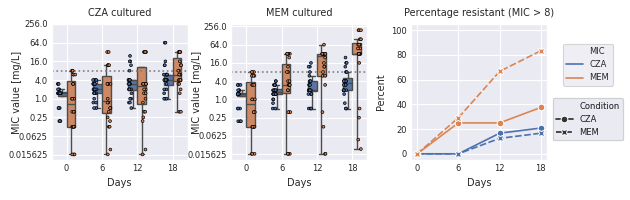

In [18]:
fig = df_mic_time.pipe(plot_all_mic)
savefig(fig, "mic_over_time")

# Figure 2

## MIC

In [20]:
df_mic_day18 = (
    df_mic_time
    .query("Days == 18 and Strain in @config['selected_strains']")
    .replace({"Strain": config["new_strain_labels"]})
    .rename(columns=lambda x: x.lower())
)

df_mic_after18 = (
    df_mic
    .melt(
        id_vars=["strain", "source", "condition"], 
        value_vars=["cza_mic", "mem_mic"], 
        var_name="mic", 
        value_name="mic_value"
    )
    .replace({
        "condition": {"P": "PAR", "C": "CZA", "M": "MEM"}, 
        "mic": {"cza_mic": "CZA", "mem_mic": "MEM"}
    })
    .query("strain not in ('$7_B$', '$8_A$')")
)

df_mic_diff = (
    pd.merge(
        df_mic_day18,
        df_mic_after18,
        how="left",
        on=["strain", "condition", "mic"], 
        suffixes=("_day18", "_over18")
    )
    .drop(columns=["days", "parentstrain"])
    .rename(columns={"mic_value_day18": "Day 18", "mic_value_over18": "Final"})
    .melt(id_vars=["strain", "condition", "mic", "source"], value_name="mic_value", var_name="time")
    .rename(columns={
        "time": "Time",
        "condition": "Condition", 
        "mic": "MIC", 
        "source": "Source", 
        "mic_value": "MIC value", 
        "strain": "Strain"
    })
    .sort_values(["Strain", "Condition", "MIC"])
    .reset_index(drop=True)
)

Values on lines 162-164 in the paper:

In [23]:
(
    df_mic_after18
    .query("mic_value >= 8")
    .groupby(["condition", "mic"], as_index=False)
    .strain
    .apply(list)
    .assign(num_strains=lambda x: x.strain.apply(len))
)

,condition,mic,strain,num_strains
0,CZA,CZA,"[$1_B$, $2_C$, $4_C$, $5_B$]",4
1,CZA,MEM,"[$1_B$, $4_C$, $5_B$, $6_C$]",4
2,MEM,CZA,"[$1_B$, $6_C$]",2
3,MEM,MEM,"[$1_B$, $3_C$, $4_C$, $5_B$, $6_C$]",5


In [24]:
(
    df_mic_after18
    .query("mic_value == 8")
    .groupby(["condition", "mic"], as_index=False)
    .strain
    .apply(list)
)

,condition,mic,strain
0,CZA,MEM,"[$5_B$, $6_C$]"


Figure 2a:

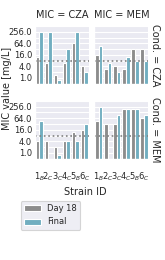

In [25]:
pal = sns.color_palette(n_colors=10)
g = (
    sns.FacetGrid(
        df_mic_diff,
        row="Condition",
        col="MIC",
        height=1,
        aspect=2,
        margin_titles=True
    )
    .map_dataframe(
        sns.barplot, 
        x="Strain", 
        y="MIC value", 
        hue="Time", 
        order=df_mic_diff.Strain.unique(),
        palette=[pal[7], pal[9]],
    )
    .add_legend(frameon=True, loc="lower left", bbox_to_anchor=(0.1, 0.1))
    .set(ylabel="", xlabel="")
    .refline(y=8, ls=":", color="gray")
    .set_titles(row_template="Cond. = {row_name}", col_template="MIC = {col_name}")
)

for ax in g.axes.flatten():
    ax.set_yscale("log", base=2)
yticks = 2.0**np.arange(-1, 10)
g.set(yticks=yticks, yticklabels=[x if i%2 else None for i, x in enumerate(yticks)])
# g.pipe(add_barplot_values, zorder=1, rotation=90, fontsize=5, fmt='%.1f')
g.tick_params(axis="y", pad=-3)
g.figure.text(0.01, 0.66, "MIC value [mg/L]", va="center", rotation=90)
g.figure.text(0.52, 0.25, "Strain ID", ha="center")
g.figure.set_size_inches(1.65, 2.6)
g.figure.subplots_adjust(left=0.21, hspace=0.3, wspace=0.1, right=0.9, bottom=0.39, top=0.9)
savefig(g, "mic_day18_vs_final")

Values in lines 145-149:

In [27]:
def mic_thresholds(value):
    if value > 8:
        return "resistant"
    elif value == 8:
        return "intermediate"
    else:
        return "susceptible"
    
(
    df_mic_after18
    .query("condition != 'PAR'")
    .assign(resistance=lambda x: x.mic_value.apply(mic_thresholds))
    .groupby(["condition", "mic", "resistance"])
    .agg(
        num_strains=pd.NamedAgg(column="strain", aggfunc="count"),
        strain=pd.NamedAgg(column="strain", aggfunc=set),
    )
)

num_strains                               strain
condition mic resistance                                                    
CZA       CZA resistant               4         {$1_B$, $5_B$, $2_C$, $4_C$}
              susceptible             2                       {$3_C$, $6_C$}
          MEM intermediate            2                       {$5_B$, $6_C$}
              resistant               2                       {$1_B$, $4_C$}
              susceptible             2                       {$3_C$, $2_C$}
MEM       CZA resistant               2                       {$1_B$, $6_C$}
              susceptible             3                {$3_C$, $5_B$, $4_C$}
          MEM resistant               5  {$5_B$, $6_C$, $3_C$, $1_B$, $4_C$}

## GO terms + mutations

In [29]:
go_terms_t = (
    df_t_lfc
    .query("padj < 0.05 and abs(log2fc) > 1")
    .groupby(["comparison", "strain"], group_keys=True)
    .gene_id
    .apply(
        lambda x: 
        get_ora(",".join(list(x.unique())), 208964, cache=cache)
        .assign(list_size=len(x.unique()), ref_size=5564)
    )
    # .apply(lambda x : get_ora(",".join(list(x.unique())), 208964, cache_file=".go_terms.sqlite"))
    .reset_index()
    .drop(columns="level_2")
    .assign(omics="Transcriptomics")
)

go_terms_p = (
    df_p_lfc
    .query("padj < 0.05 and abs(log2fc) > 1")
    .dropna(subset="prot_id")
    .groupby(["comparison", "strain"], group_keys=True)
    .prot_id
    .apply(
        lambda x: 
        get_ora(",".join(list(x.unique())), 208964, cache=cache)
        .assign(list_size=len(x.unique()), ref_size=5564)
    )
    # .apply(lambda x : get_ora(",".join(list(x.unique())), 208964, cache_file=".go_terms.sqlite"))
    .reset_index()
    .drop(columns="level_2")
    .assign(omics="Proteomics")
)

# We merge both omics and add number of strains 
# for which each go terms appears significantly
go_terms_fig2 = (
    pd.concat([go_terms_t, go_terms_p], ignore_index=True)
    .pipe(lambda x: x.merge(
        x
        .query("fdr < 0.001")
        .pivot_table(index=["comparison", "term", "omics"], values="strain", aggfunc=list)
        .reset_index()
        .assign(num_strains=lambda y: y.strain.apply(len))
        .explode("strain"),
        how="left",
        on=["term", "comparison", "omics", "strain"]
    ))
)

comp_map = {
    "CZA vs PAR": 1,
    "MEM vs PAR": 2,
    "CZA vs MEM": 3,
    "CZA vs PAR, MEM vs PAR": 4,
    "CZA vs MEM, CZA vs PAR": 5,
    "CZA vs MEM, MEM vs PAR": 6,
    "CZA vs MEM, CZA vs PAR, MEM vs PAR": 7
}

new_cols = pd.MultiIndex.from_product(
    [
        ["Transcriptomics", "Proteomics"], 
        config["new_strain_labels"].values()
    ], 
    names=["omics", "strain"]
)

go_terms_set = set(go_terms_fig2.query("fdr < 0.001 and ((omics == 'Transcriptomics' and num_strains > 1) or omics == 'Proteomics')").term)
go_terms_heatmap = (
    go_terms_fig2
    .query("term in @go_terms_set and fdr < 0.05")
    .pivot_table(index="term", columns=["omics", "strain"], values="comparison", aggfunc=", ".join)
    .replace(comp_map)
    .reindex(columns=new_cols)
    .sort_index(key=lambda x: x.str.len())
)

df_num_mut = (
    df_mut2
    .groupby(["condition", "strain", "type"], as_index=False)
    .agg(num_genes=pd.NamedAgg("pos", "count"))
    .replace({"condition": {"C": "CZA", "M": "MEM", "P": "PAR"}})
    .pivot(index=["condition", "strain"], columns="type", values="num_genes")
    .pipe(lambda x: x.reindex(x.index.insert(7, ("MEM", "$2_C$"))))
)

# go_terms_heatmap  #.unstack().reset_index(name="conditions").dropna().query("conditions == 7")

Values on line 157:

In [30]:
(
    df_mut2
    .query("strain != '$1_B$'")
    .groupby(["strain", "condition"], as_index=True)
    .agg(num=pd.NamedAgg("pos", "count"))
    .pipe(lambda x: {"min": x.num.min(), "max": x.num.max()})
)

{'min': 3, 'max': 29}

Values used on lines 176-177:

In [31]:
df_mut2_num = (
    df_mut2
    .groupby(["gene_name", "condition"], as_index=False)
    .agg(
        strains=pd.NamedAgg("strain", set), 
        num_mutations=pd.NamedAgg("strain", "nunique")
    )
    .sort_values(["num_mutations", "gene_name"], ascending=False)
)

gene_names = df_mut2_num.query("num_mutations > 1").gene_name
(
    df_mut2_num
    .query("num_mutations > 1 or gene_name in @gene_names")
)

,gene_name,condition,strains,num_mutations
86,ftsI,MEM,"{$4_C$, $1_B$, $5_B$, $3_C$}",4
60,dacB,CZA,"{$3_C$, $5_B$, $2_C$, $6_C$}",4
153,oprD,MEM,"{$1_B$, $5_B$, $4_C$}",3
170,phoQ,MEM,"{$3_C$, $4_C$}",2
140,nalD,MEM,"{$3_C$, $4_C$}",2
134,mpl,MEM,"{$1_B$, $6_C$}",2
128,mexR,MEM,"{$1_B$, $6_C$}",2
126,mexB,MEM,"{$1_B$, $5_B$}",2
85,ftsI,CZA,"{$1_B$, $4_C$}",2
66,dipA,MEM,"{$1_B$, $4_C$}",2


Values on lines 183-185 in the paper:

In [32]:
def get_max_by_strains_comps(data, col):
    return (
        data
        .query("padj < 0.05 and abs(log2fc) > 1")
        .groupby(["strain", "comparison"], as_index=False)
        .agg(num=pd.NamedAgg(col, "count"))
        .num
        .max()
    )

df_t_lfc.pipe(get_max_by_strains_comps, "gene_id"), df_p_lfc.pipe(get_max_by_strains_comps, "prot_id") 

(1390, 888)

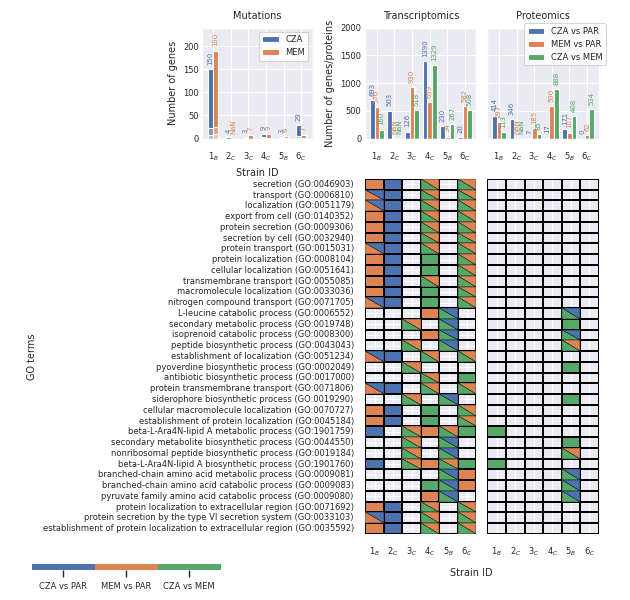

In [34]:
def add_triangles(indices, colors, ax, **kwargs):
    # default options
    opts = dict(closed=True, fill=True, ec="black", lw=2)
    opts.update(kwargs)
    for y, x in indices:
        ax.add_patch(Polygon(
            [(x, y), (x+1, y), (x + 1, y + 1)], fc=colors[0], **opts
        ))
        ax.add_patch(Polygon(
            [(x, y), (x, y+1), (x + 1, y + 1)], fc=colors[1], **opts
        ))


# Heatmaps
tri_colors_map = {
    4: sns.color_palette()[:2],
    5: [sns.color_palette()[0], sns.color_palette()[2]],
    6: sns.color_palette()[1:3]
}

fig, axs = plt.subplots(2, 2, figsize=(6.3, 6), height_ratios=[2, 5])
fig.subplots_adjust(left=0.58, right=0.95, hspace=0.1, wspace=0.1, top=0.98)
cbar_ax = fig.add_axes([0.05, 0.05, 0.3, 0.01])
for ax in axs[0, :]:
    ax.set_box_aspect(1.0)


sns.heatmap(
    go_terms_heatmap.Transcriptomics,
    cmap=sns.color_palette("deep", 3), 
    linecolor="black",
    linewidths=0.3,
    vmin=0.5,
    vmax=3.5,
    cbar=False,
    ax=axs[1, 0],
)

for idx, colors in tri_colors_map.items():
    add_triangles(
        zip(*np.where(go_terms_heatmap.Transcriptomics == idx)),
        colors, 
        axs[1, 0], 
        lw=0.3
    )
    
sns.heatmap(
    go_terms_heatmap.Proteomics,
    cmap=sns.color_palette("deep", 3), 
    linecolor="black",
    linewidths=0.3,
    yticklabels=False,
    vmin=0.5,
    vmax=3.5,
    cbar=True,
    cbar_ax=cbar_ax,
    cbar_kws=dict(orientation="horizontal"),
    ax=axs[1, 1],
)

for idx, colors in tri_colors_map.items():
    add_triangles(
        zip(*np.where(go_terms_heatmap.Proteomics == idx)),
        colors, 
        axs[1, 1],
        lw=0.3
    )

# Number of significantly up- or down-regulated genes and proteins barplots
barplots_opts = dict(
    kind="bar", 
    stacked=False,  # Maybe change this
    width=0.8,
    rot=0, 
    color=sns.color_palette()[:3],
    legend=False
)
(
    df_t_lfc
    .query("padj < 0.05 and abs(log2fc) > 1")
    .groupby(["strain", "comparison"], as_index=False)["gene_id"]
    .count()
    .rename(columns={"gene_id": "num genes"})
    .pivot(index="strain", columns="comparison", values="num genes")
    .reindex(columns=["CZA vs PAR", "MEM vs PAR", "CZA vs MEM"])
    .plot(ax=axs[0, 0], **barplots_opts)
)

(
    df_p_lfc
    .query("padj < 0.05 and abs(log2fc) > 1")
    .groupby(["strain", "comparison"], as_index=False)["prot_id"]
    .count()
    .rename(columns={"prot_id": "num proteins"})
    .pivot(index="strain", columns="comparison", values="num proteins")
    .reindex(columns=["CZA vs PAR", "MEM vs PAR", "CZA vs MEM"])
    .plot(ax=axs[0, 1], **barplots_opts)
)
axs[0, 1].legend(loc="center", bbox_to_anchor=(0.7, 0.85), facecolor="white")

colorbar = axs[1, 1].collections[0].colorbar
colorbar.set_ticks([1, 2, 3])
colorbar.set_ticklabels(["CZA vs PAR", "MEM vs PAR", "CZA vs MEM"])

axs[0, 0].set(ylim=[0, 2000], xlabel=None, ylabel="Number of genes/proteins", title="Transcriptomics")
axs[0, 1].set(ylim=[0, 2000], xlabel=None, ylabel=None, yticklabels=[], title="Proteomics")
axs[1, 0].set(xlabel=None, ylabel="GO terms")
axs[1, 1].set(xlabel=None, ylabel=None)
axs[0, 0].tick_params(axis="y", pad=-2)
    
bar_label_opts = dict(label_type='edge', rotation=90, padding=3, fontsize=5)
for i in range(3):
    axs[0, 0].bar_label(axs[0, 0].containers[i], color=sns.color_palette()[i], **bar_label_opts)
    axs[0, 1].bar_label(axs[0, 1].containers[i], color=sns.color_palette()[i], **bar_label_opts)

# Mutations subplot
pos = axs[0, 0].get_position()
ax_mut = fig.add_axes([0.32, pos.y0, pos.width, pos.height])

mut_opts = dict(kind="bar", stacked=True, width=0.8/3, ax=ax_mut, rot=0)
cza_color, mem_color = sns.color_palette()[:2]
(
    df_num_mut
    .loc["CZA"]
    .rename(columns=lambda x: f"CZA {x}")
    .plot(position=1, color=sns.light_palette(cza_color, 8)[1::2], **mut_opts)
)
(
    df_num_mut
    .loc["MEM"]
    .rename(columns=lambda x: f"MEM {x}")
    .plot(position=0, color=sns.light_palette(mem_color, 8)[1::2], **mut_opts)
)
ax_mut.set(title="Mutations", ylabel="Number of genes", xlabel="Strain ID", ylim=(0, 240), xlim=axs[0, 0].get_xlim())
ax_mut.tick_params(axis="y", pad=-3)
ax_mut.bar_label(ax_mut.containers[3], color=cza_color, **bar_label_opts)
ax_mut.bar_label(ax_mut.containers[-1], color=mem_color, **bar_label_opts)
ax_mut.legend([ax_mut.containers[3][0], ax_mut.containers[-1][0]], ["CZA", "MEM"], facecolor="white")
# sns.move_legend(ax_mut, loc="upper right", bbox_to_anchor=(1.1, 1.1), facecolor="white", ncol=1, fontsize=4)
    
fig.text(0.715, 0.04, "Strain ID")

# Fix bar labels due to 2_C MEM samples being removed
for child in ax_mut.get_children():
    if isinstance(child, matplotlib.text.Annotation) and child.get_text() == "0":
        child.set_text("NaN")    
    
for child in axs[0, 0].get_children():
    if isinstance(child, matplotlib.text.Annotation) and child.get_text() == "0":
        child.set_text("NaN")

chosen_nans = [False, True, True]
nan_idx = 0
for child in axs[0, 1].get_children():
    if isinstance(child, matplotlib.text.Annotation) and child.get_text() == "0":
        if chosen_nans[nan_idx]:
            child.set_text("NaN")
        nan_idx += 1
        
savefig(fig, "go_terms_num_strains")

Check on number of mutations plot above:

In [35]:
(
    df_num_mut
    .sum(axis=1)
    .reset_index(name="total_mut")
    .replace(0, np.nan)
    .sort_values(["strain", "condition"])
)

,condition,strain,total_mut
0,CZA,$1_B$,150.0
6,MEM,$1_B$,190.0
1,CZA,$2_C$,4.0
7,MEM,$2_C$,NaN
2,CZA,$3_C$,3.0
8,MEM,$3_C$,7.0
3,CZA,$4_C$,9.0
9,MEM,$4_C$,9.0
4,CZA,$5_B$,3.0
10,MEM,$5_B$,6.0


# Figure 3

## PCA

In [36]:
def get_pca_factors(data, pca_obj):
    data_transformed = data.transpose().pipe(pca_obj.fit_transform)
    cols = [f"PC{i+1}" for i in range(data_transformed.shape[1])]
    return (
        pd.DataFrame(data_transformed, columns=cols)
        .assign(group=data.columns)
        .pipe(
            lambda x: x.assign(
            **x.group.str.split("_", expand=True)
            .rename(columns={0: "strain", 1: "condition", 2: "replicate"})
        ))
    )

In [37]:
df_t_norm = pd.read_csv("Output/DESeq2/rlog.csv", index_col=0)
pca_t = PCA(2)
df_t_pca = (
    df_t_norm
    .pipe(get_pca_factors, pca_t)
    .assign(omics="Transcriptomics")
)

df_p_norm = pd.read_csv("Output/Proteomics/normalised.csv", index_col=0)
pca_p = PCA(2)
df_p_pca = (
    df_p_norm
    .dropna()
    .pipe(get_pca_factors, pca_p)
    .assign(omics="Proteomics")
)

df_pca = (
    pd.concat([df_t_pca, df_p_pca])
    .query("strain in @config['selected_strains']")
    .replace(
        {
            "strain": config['new_strain_labels'], 
            "condition": {"M": "MEM", "C": "CZA", "P": "PAR"}
        }
    )
)

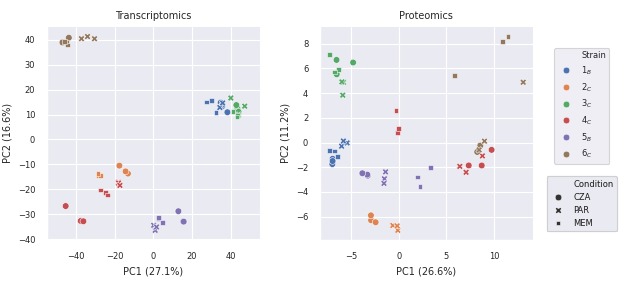

In [38]:
g = (
    sns.FacetGrid(
        df_pca.rename(columns={"strain": "Strain", "condition": "Condition"}), 
        col="omics",
        sharex=False,
        sharey=False,
        height=3.0,
        aspect=1.0
    )
    .map_dataframe(
        sns.scatterplot,
        x="PC1", 
        y="PC2", 
        hue="Strain", 
        style="Condition", 
    )
    # .add_legend(loc="center right", bbox_to_anchor=(0.98, 0.55), frameon=True)
    .set_titles(row_template="{row_name}", col_template="{col_name}")
    .pipe(set_box_aspect)
)

g.axes[0, 0].set(
    xlabel=f"PC1 ({100*pca_t.explained_variance_ratio_[0]:.1f}%)", 
    ylabel=f"PC2 ({100*pca_t.explained_variance_ratio_[1]:.1f}%)",
    xlim=(-55, 55)
)
g.axes[0, 1].set(
    xlabel=f"PC1 ({100*pca_p.explained_variance_ratio_[0]:.1f}%)", 
    ylabel=f"PC2 ({100*pca_p.explained_variance_ratio_[1]:.1f}%)",
    # xlim=(-105, 110)
)
# g.figure.subplots_adjust(left=0.13, wspace=0.25, right=0.88)
# g.tight_layout()
g.figure.set_size_inches(6.3, 3)
g.figure.subplots_adjust(bottom=0.2, left=0.07, right=0.85, wspace=0.25,)
separate_legends(g.axes[0, 1], 7, bbox_to_anchor=(1.23, 0.4), ysep=0.23)
savefig(g, "pca_both_selected_strains")

## Naive

In [39]:
df_counts_both = (
    df_lfc
    .query(
        "padj_p < 0.05 and padj_t < 0.05 "
        "and (abs(log2fc_t) > 1 or abs(log2fc_p) > 1) "
    )
    # .groupby(["comparison", "gene_id", "gene_name"], as_index=False)
    .groupby(["comparison", "gene_id"], as_index=False)
    .strain
    .nunique()
    .assign(omics="Both")
    .merge(df_uniprot.get(["gene_id", "gene_name", "prot_id", "prot_name"]), on="gene_id", how="left")
)

df_counts_t = (
    df_t_lfc
    .query("padj < 0.05 and abs(log2fc) > 1")
    .groupby(["comparison", "gene_id"], as_index=False)
    .strain
    .nunique()
    .assign(omics="Transcriptomics")
    .merge(df_uniprot.get(["gene_id", "gene_name", "prot_id", "prot_name"]), on="gene_id", how="left")
)

df_counts_p = (
    df_p_lfc
    .query("padj < 0.05 and abs(log2fc) > 1")
    .groupby(["comparison", "prot_id"], as_index=False)
    .strain
    .nunique()
    .assign(omics="Proteomics")
    .merge(df_uniprot.get(["prot_id", "gene_id", "gene_name"]), how="left", on="prot_id")
    .assign(gene_id=lambda x: x.gene_id.fillna(x.prot_id))
)

df_counts_all = pd.concat([df_counts_both, df_counts_t, df_counts_p])

df_num_strains_all = (
    df_counts_all
    .groupby(["strain", "comparison", "omics"], group_keys=True)
    .gene_id
    .nunique()
    .reset_index()
    .rename(columns={
        "gene_id": "num_genes",
        "strain": "num_strains"
    })
)

Values used on lines 218-219:

In [40]:
df_t_lfc.gene_id.unique().shape[0], df_p_lfc.prot_id.unique().shape[0]

(5563, 4028)

In [42]:
(
    df_num_strains_all
    .query("comparison != 'CZA vs MEM'")
    .groupby(["omics", "comparison"], as_index=False)
    .agg(num_genes=pd.NamedAgg("num_genes", "sum"))
)

,omics,comparison,num_genes
0,Both,CZA vs PAR,320
1,Both,MEM vs PAR,401
2,Proteomics,CZA vs PAR,809
3,Proteomics,MEM vs PAR,984
4,Transcriptomics,CZA vs PAR,2178
5,Transcriptomics,MEM vs PAR,1895


Values used on lines 221-223:

In [43]:
(
    df_num_strains_all
    .query("comparison != 'CZA vs MEM' and omics != 'Transcriptomics'")
    .groupby(["omics", "comparison"])
    .num_genes
    .sum()
    .reset_index()
    .pivot(columns="omics", index="comparison", values="num_genes")
    .assign(ratio=lambda x: x.Both / x.Proteomics)
)

omics,Both,Proteomics,ratio
comparison,,,
CZA vs PAR,320,809,0.39555
MEM vs PAR,401,984,0.40752


In [44]:
(
    df_t_lfc.query(
        "gene_name == 'ampC' and comparison != 'CZA vs MEM' and "
        "padj < 0.05 and abs(log2fc) > 1"
    )
    .get(["comparison", "strain", "log2fc", "regulation"])
    .sort_values(["comparison", "strain"])
)

,comparison,strain,log2fc,regulation
4107,CZA vs PAR,$1_B$,-1.275249,Down
20796,CZA vs PAR,$2_C$,9.869785,Up
26359,CZA vs PAR,$3_C$,9.564736,Up
59737,CZA vs PAR,$5_B$,7.055891,Up
76426,CZA vs PAR,$6_C$,9.103002,Up
9670,MEM vs PAR,$1_B$,7.047276,Up
31922,MEM vs PAR,$3_C$,2.046526,Up
81989,MEM vs PAR,$6_C$,3.754108,Up


GO terms need on lines 223-226:

In [45]:
go_terms_fig3 = (
    df_counts_all
    .dropna(subset="gene_id")
    .assign(atleast_strains=lambda x: x.strain.apply(lambda y: np.arange(1, y+1)))  # atleast
    .explode("atleast_strains")  # atleast
    .groupby(["omics", "comparison", "atleast_strains"])  # atleast
    # .groupby(["omics", "comparison", "strain"])
    .gene_id
    .apply(
        lambda x: 
        get_ora(",".join(x), 208964, cache=cache)
        .assign(list_size=len(x), ref_size=5564)
    )
    .reset_index()
    .drop(columns="level_3")
)

(
    go_terms_fig3
    .query("omics == 'Both' and comparison != 'CZA vs MEM'")
    .groupby("comparison")
    .apply(lambda x: x.nsmallest(5, "fdr"))
    .query("fdr < 0.05")
)

omics  comparison  atleast_strains  number_in_list  \
comparison                                                            
CZA vs PAR 8828   Both  CZA vs PAR                1               8   
           8830   Both  CZA vs PAR                1               5   
           8829   Both  CZA vs PAR                1               5   
           8832   Both  CZA vs PAR                1              15   
           8834   Both  CZA vs PAR                1               5   
MEM vs PAR 15453  Both  MEM vs PAR                1               2   
           15450  Both  MEM vs PAR                1              35   
           15454  Both  MEM vs PAR                1               7   
           15452  Both  MEM vs PAR                1               0   
           15449  Both  MEM vs PAR                1               7   

                  fold_enrichment       fdr   expected  number_in_reference  \
comparison                                                                    
CZA vs PAR 8828          9.935714  0.000537   0.805176                   14   
           8830         12.419643  0.008568   0.402588                    7   
           8829         12.419643  0.012852   0.402588                    7   
           8832          3.068382  0.035963   4.888569                   85   
           8834          8.693750  0.038133   0.575126                   10   
MEM vs PAR 15453         0.134712  0.020441  14.846513                  206   
           15450         2.111460  0.021373  16.576204                  230   
           15454         6.070449  0.022791   1.153127                   16   
           15452         0.000000  0.023199  10.161934                  141   
           15449         7.471322  0.024825   0.936916                   13   

                        pValue  \
comparison                       
CZA vs PAR 8828   2.433817e-07   
           8830   1.164636e-05   
           8829   1.164636e-05   
           8832   8.147588e-05   
           8834   1.209474e-04   
MEM vs PAR 15453  4.630834e-05   
           15450  1.936856e-05   
           15454  6.196057e-05   
           15452  4.204710e-05   
           15449  1.124840e-05   

                                                               term  \
comparison                                                            
CZA vs PAR 8828   branched-chain amino acid catabolic process (G...   
           8830            L-leucine catabolic process (GO:0006552)   
           8829   pyruvate family amino acid catabolic process (...   
           8832     alpha-amino acid catabolic process (GO:1901606)   
           8834            L-leucine metabolic process (GO:0006551)   
MEM vs PAR 15453        nucleic acid metabolic process (GO:0090304)   
           15450           nitrogen compound transport (GO:0071705)   
           15454                oligopeptide transport (GO:0006857)   
           15452                 RNA metabolic process (GO:0016070)   
           15449        phenazine biosynthetic process (GO:0002047)   

                 plus_minus  list_size  ref_size  
comparison                                        
CZA vs PAR 8828           +        320      5564  
           8830           +        320      5564  
           8829           +        320      5564  
           8832           +        320      5564  
           8834           +        320      5564  
MEM vs PAR 15453          -        401      5564  
           15450          +        401      5564  
           15454          +        401      5564  
           15452          -        401      5564  
           15449          +        401      5564

Gene names used on line 226:

In [46]:
df_counts_all.query("strain >= 4 and omics == 'Both' and comparison != 'CZA vs MEM'")

,comparison,gene_id,strain,omics,gene_name,prot_id,prot_name
1008,MEM vs PAR,PA0425,4,Both,mexA,P52477,MEXA_PSEAE
1009,MEM vs PAR,PA0426,4,Both,mexB,P52002,MEXB_PSEAE


Gene names used on lines 233-235:

In [47]:
df_counts_all.query("omics == 'Transcriptomics' and comparison == 'CZA vs PAR' and strain >= 5")

,comparison,gene_id,strain,omics,gene_name,prot_id,prot_name
3224,CZA vs PAR,PA3186,5,Transcriptomics,oprB,Q51485,PORB_PSEAE
3225,CZA vs PAR,PA3187,5,Transcriptomics,PA3187,Q9HZ51,Q9HZ51_PSEAE
3226,CZA vs PAR,PA3188,5,Transcriptomics,PA3188,Q9HZ50,Q9HZ50_PSEAE
3227,CZA vs PAR,PA3189,5,Transcriptomics,PA3189,Q9HZ49,Q9HZ49_PSEAE
3228,CZA vs PAR,PA3190,5,Transcriptomics,PA3190,Q9HZ48,Q9HZ48_PSEAE
3572,CZA vs PAR,PA4110,5,Transcriptomics,ampC,P24735,AMPC_PSEAE
3573,CZA vs PAR,PA4111,5,Transcriptomics,PA4111,Q9HWR9,Q9HWR9_PSEAE


Figure:

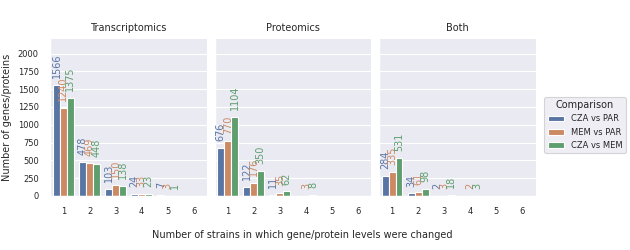

In [48]:
g = (
    sns.FacetGrid(
        df_num_strains_all, 
        col="omics", 
        height=1.9, 
        aspect=1.0,
        ylim=(0, 2200), 
        col_order=("Transcriptomics", "Proteomics", "Both")
    )
    .map_dataframe(
        sns.barplot, 
        x="num_strains", 
        y="num_genes", 
        order=np.arange(1, 7),
        hue="comparison", 
        hue_order=("CZA vs PAR", "MEM vs PAR", "CZA vs MEM"), 
        palette=sns.color_palette("deep", 3)
    )
    .set_titles("{col_name}")
    .add_legend(title="Comparison", loc="center right", bbox_to_anchor=(1.0, 0.5), frameon=True)
    .set_axis_labels(x_var="", y_var="Number of genes/proteins")
    .pipe(add_barplot_values)
    .pipe(set_box_aspect)
)

g.figure.set_size_inches(6.3, 2.5)
# g.tight_layout()
g.figure.subplots_adjust(bottom=0.2, left=0.08, right=0.85, wspace=0.05)
g.figure.text(0.48, 0.05, "Number of strains in which gene/protein levels were changed", ha="center")
savefig(g, "naive_analysis")

# Figure 4

## PLS-DA factorplots

In [49]:
class PLSDA(object):
    def __init__(self, data, mic, mic_threshold=30, n_comp=2, threshold=0.5, strain_to_leave=None, metadata_cols=None):
        non_data_cols = ["isolate", "strain", "condition", "replicate", "replicate2", "cza_mic", "mem_mic"]
        if metadata_cols is not None:
            non_data_cols += metadata_cols
        self.threshold = threshold

        self.labels = data.drop(columns=non_data_cols).columns.tolist()
        
        self.x_test = None
        self.y_test = None
        if strain_to_leave is not None:
            test_set = data.query("strain == @strain_to_leave")
            self.x_test = test_set.drop(columns=non_data_cols).to_numpy()
            self.y_test = test_set[f"{mic.lower()}_mic"].apply(lambda x: 1 if x>mic_threshold else 0).to_numpy()
            data = data.query("strain != @strain_to_leave")

        self.meta = data.get(non_data_cols)
        self.mic = mic
        self.mic_threshold = mic_threshold
        self.n_comp = n_comp
        self.y_train = data[f"{mic.lower()}_mic"].apply(lambda x: 1 if x>mic_threshold else 0).to_numpy()
        self.x_train = data.drop(columns=non_data_cols).to_numpy()

        self.pls = PLSRegression(n_components=n_comp)
        self.pls.fit(self.x_train, self.y_train)
        
    def get_y_pred(self, x):
        return [1 if yp > self.threshold else 0 for yp in self.pls.predict(x)]
    
    def get_y_pred_train(self):
        return self.get_y_pred(self.x_train)
    
    def get_y_pred_test(self):
        if self.y_test is not None:
            return self.get_y_pred(self.x_test)
        return None
    
    def transform_train(self):
        return self.pls.transform(self.x_train, self.y_train)

    def get_factors(self):
        x_pls, y_pls = self.transform_train()
        factor_cols = [f"factor_{i}" for i in range(1, self.n_comp+1)]
        return (
            pd.DataFrame(x_pls, columns=factor_cols)
            .assign(
                mic_level=["high" if x else "low" for x in self.y_train],
                mic=self.mic,
                y=self.y_train,
                y_pred=self.get_y_pred_train(),
                condition=self.meta.condition.tolist()
            )
            .reset_index(drop=True)
        )
    
    def get_accuracy(self, x, y):
        return accuracy_score(self.get_y_pred(x), y)
    
    def get_accuracy_train(self):
        return self.get_accuracy(self.x_train, self.y_train)
    
    def get_accuracy_test(self):
        if self.y_test is not None:
            return self.get_accuracy(self.x_test, self.y_test)
        return None
    
    def get_loadings(self):
        loadings = self.pls.x_loadings_
        return (
            pd.DataFrame(
                loadings, 
                columns=[f"pls{i}" for i in range(1, loadings.shape[1]+1)]
            )
            .assign(labels=self.labels)
        )

prot2gene = df_uniprot.set_index("prot_id").get("gene_id").to_dict()
df_both = pd.concat(
    [
        df_t.assign(omics="T"), 
        df_p.dropna(axis=1).rename(columns=prot2gene).assign(omics="P")
    ]
)

In [50]:
full_models = {
    (omics, mic): PLSDA(data.dropna(axis="columns"), mic, metadata_cols=("omics", ))
    for (omics, data), mic 
    in product(df_both.groupby("omics"), ["CZA", "MEM"])
}

Values used on line 255:

In [51]:
df_full_models_factors = pd.concat([
    model.get_factors().assign(omics=omics)
    for (omics, mic), model in full_models.items()
])

df_full_acc = pd.DataFrame([
    (omics, mic, model.get_accuracy_train()) 
    for (omics, mic), model in full_models.items()
], columns=["omics", "mic", "accuracy_train"])

df_full_acc

,omics,mic,accuracy_train
0,P,CZA,0.960784
1,P,MEM,1.000000
2,T,CZA,0.980392
3,T,MEM,0.960784


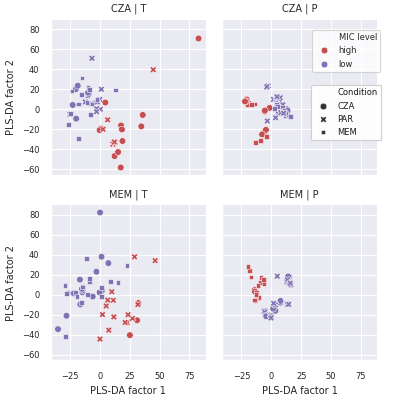

In [52]:
g = (
    sns.FacetGrid(
        df_full_models_factors
        .replace({
            "condition": {"M": "MEM", "C": "CZA", "P": "PAR"}
        })
        .rename(
            columns={"mic_level": "MIC level", "condition": "Condition"}
        ),
        col="omics", 
        col_order=("T", "P"),
        row="mic", 
        row_order=("CZA", "MEM")
    )
    .map_dataframe(
        sns.scatterplot, 
        x="factor_1", 
        y="factor_2", 
        style="Condition", 
        hue="MIC level", 
        palette=sns.color_palette("deep", 5)[3:5]
    )
    .set_titles(col_template="{col_name}", row_template="{row_name}")
    .set_axis_labels(x_var="PLS-DA factor 1", y_var="PLS-DA factor 2")
    # .add_legend(loc="upper right", bbox_to_anchor=(0.97, 0.93), frameon=True)
    .pipe(set_box_aspect)
)
g.figure.set_size_inches(4.0, 4.0)
# g.figure.tight_layout()
g.figure.subplots_adjust(left=0.12, bottom=0.1, top=0.95, right=0.95, hspace=0.2)
separate_legends(g.axes[0, 1], bbox_to_anchor=(0.8, 0.6), facecolor="white")
savefig(g, "plsda_all_factorplots")

## PLS-DA leave-one-out accuracies

In [53]:
loo_models = {
    (omics, mic, strain): 
    PLSDA(
        data.dropna(axis="columns"), 
        mic, 
        strain_to_leave=strain, metadata_cols=("omics", )
    )
    for (omics, data), mic, strain 
    in product(
        df_both.groupby("omics"), 
        ["CZA", "MEM"], 
        config["new_strain_labels"].values()
    )
}

In [54]:
df_loo_acc = pd.DataFrame([
    (omics, mic, strain, model.get_accuracy_train(), model.get_accuracy_test())
    for (omics, mic, strain), model in 
    loo_models.items()
], columns=("omics", "mic", "strain", "accuracy_train", "accuracy_test"))

df_loo_loadings = pd.concat([
    (
        model
        .get_loadings()
        .melt(id_vars="labels", var_name="pls", value_name="loadings")
        .replace({"pls": {"pls1": 1, "pls2": 2}})
        .rename(columns={"labels": "gene_id"})
        .assign(omics=omics, mic=mic, strain=strain)
    )
    for (omics, mic, strain), model in 
    loo_models.items()
])

df_top_genes_both = (
    df_loo_loadings
    .assign(abs_loadings=lambda x: np.absolute(x.loadings))
    .groupby(["pls", "omics", "mic", "strain"], group_keys=False)
    .apply(lambda x: x.nlargest(100, "abs_loadings"))
    .groupby(["gene_id", "omics", "mic"])
    .agg({"strain": set, "loadings": "mean"})
    .reset_index()
    .assign(num_strains = lambda x: x.strain.apply(len))
    .sort_values("num_strains", ascending=False, ignore_index=True)
    .merge(
        df_uniprot.get(["gene_id", "gene_name"]),
        on="gene_id",
        how="left"
    )
    .query("num_strains >= 1")
)

df_plsda_with_pvals = pd.merge(
    df_both_w_pvals.query("padj < 0.01"),
    df_top_genes_both.query("num_strains >= 5"), 
    how="inner", 
    on=["gene_id", "mic", "omics"]
)

df_num_genes = (
    df_top_genes_both
    .groupby(["omics", "mic", "num_strains"], as_index=False)["gene_id"]
    .count()
    .rename(columns={"gene_id": "num_genes"})
    # .replace({"omics": {"P": "Proteomics", "T": "Transcriptomics"}})
    .assign(mic=lambda x: x.mic.str.upper(), mic_omics=lambda x: x.mic + "|" + x.omics)
    .pivot(index="num_strains", columns="mic_omics", values="num_genes")
    .reindex(columns=["CZA|T", "MEM|T", "CZA|P", "MEM|P"])
)

go_terms_fig4 = (
    df_top_genes_both
    .query("num_strains >= 5")
    .groupby(["omics", "mic"])
    .gene_id
    .apply(
        lambda x: 
        get_ora(",".join(list(x)), 208964, cache=cache)
        .assign(list_size=len(x), ref_size=5564)
    )
    .reset_index()
    .drop(columns="level_2")
)

go_terms_selected = (
    go_terms_fig4
    .groupby(["omics", "mic"])
    .apply(lambda x: x.nsmallest(5, ["fdr", "pValue"]))
    .reset_index(drop=True)
    .assign(
        mic_omics=lambda x: x.mic + "|" + x.omics,
        term=lambda x: x.term.str.wrap(60)
    )
    .query("number_in_list > 0")
    
    .pivot(columns="mic_omics", index="term", values="number_in_list")
    .sort_values(["MEM|P", "CZA|P", "MEM|T", "CZA|T"], ascending=False)
    .reindex(columns=["CZA|T", "MEM|T", "CZA|P", "MEM|P"])
)

Values used on line 262:

In [55]:
df_loo_acc.groupby(["omics", "mic"]).accuracy_test.median().reset_index().sort_values(["omics", "mic"], ascending=[True, False])

,omics,mic,accuracy_test
1,P,MEM,0.722222
0,P,CZA,0.666667
3,T,MEM,0.666667
2,T,CZA,0.361111


Values used on lines 266-267:

In [56]:
df_loo_loadings.dropna(subset="gene_id").groupby("omics").gene_id.nunique()

omics
P    1923
T    5563
Name: gene_id, dtype: int64

Checking to see which models had low accuracy:

In [57]:
df_loo_acc.query("accuracy_test < 0.5")

,omics,mic,strain,accuracy_train,accuracy_test
2,P,CZA,$3_C$,0.952381,0.111111
6,P,MEM,$1_B$,1.000000,0.222222
12,T,CZA,$1_B$,0.928571,0.222222
14,T,CZA,$3_C$,0.976190,0.222222
16,T,CZA,$5_B$,1.000000,0.111111
23,T,MEM,$6_C$,0.952381,0.333333


GO terms stated on lines 269-273:

In [58]:
(
    go_terms_fig4
    .groupby(["omics", "mic"])
    .apply(lambda x: x.nsmallest(5, ["fdr", "pValue"]))
    .reset_index(drop=True)
    # .query("fdr < 0.05")
)

,omics,mic,number_in_list,fold_enrichment,fdr,expected,number_in_reference,pValue,term,plus_minus,list_size,ref_size
0,P,CZA,1,370.933333,0.991643,0.002696,1,0.002696,protein unfolding (GO:0043335),+,15,5564
1,P,CZA,4,6.744242,1.000000,0.593098,220,0.002301,gene expression (GO:0010467),+,15,5564
2,P,CZA,1,370.933333,1.000000,0.002696,1,0.002696,cysteinyl-tRNA aminoacylation (GO:0006423),+,15,5564
3,P,CZA,1,370.933333,1.000000,0.002696,1,0.002696,'de novo' cotranslational protein folding (GO:...,+,15,5564
4,P,CZA,1,370.933333,1.000000,0.002696,1,0.002696,selenium compound metabolic process (GO:0001887),+,15,5564
5,P,MEM,6,6.173077,0.098411,0.971963,208,0.000312,carbohydrate derivative metabolic process (GO:...,+,26,5564
6,P,MEM,2,71.333333,0.114540,0.028037,6,0.000311,carnitine catabolic process (GO:0042413),+,26,5564
7,P,MEM,2,71.333333,0.137448,0.028037,6,0.000311,carnitine metabolic process (GO:0009437),+,26,5564
8,P,MEM,14,2.853333,0.146804,4.906542,1050,0.000067,cellular metabolic process (GO:0044237),+,26,5564
9,P,MEM,2,85.600000,0.153160,0.023364,5,0.000208,dTDP-rhamnose biosynthetic process (GO:0019305),+,26,5564


Values used on lines 275-284:

In [59]:
(
    pd.merge(
        df_both_w_pvals.query("padj < 0.05"),
        df_top_genes_both.query("num_strains >= 5"), 
        how="inner", 
        on=["gene_id", "mic", "omics"]
    )
    .query("mic == 'CZA'")
    .drop_duplicates("gene_name")
)

,gene_id,pvalue,padj,fold_change,condition,mic,omics,strain,loadings,num_strains,gene_name
0,PA0061,2.154708e-04,0.024972,2.367728,CZA,CZA,T,"{$5_B$, $3_C$, $1_B$, $2_C$, $4_C$}",0.006909,5,PA0061
2,PA0460,6.559682e-07,0.000699,1.865473,All,CZA,T,"{$5_B$, $6_C$, $3_C$, $1_B$, $4_C$}",0.010349,5,PA0460
3,PA1592,7.826820e-05,0.016020,1.965679,All,CZA,T,"{$5_B$, $3_C$, $1_B$, $2_C$, $4_C$}",0.007439,5,PA1592
4,PA3945,1.177207e-05,0.005953,1.543013,All,CZA,T,"{$5_B$, $6_C$, $1_B$, $2_C$, $4_C$}",0.024963,5,PA3945
5,PA5473,9.503282e-05,0.016020,1.777346,All,CZA,T,"{$5_B$, $6_C$, $3_C$, $1_B$, $2_C$}",0.009678,5,PA5473
16,PA0764,1.077354e-04,0.005027,1.038471,CZA,CZA,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",-0.056694,5,mucB
18,PA1338,1.077354e-04,0.005027,0.954398,CZA,CZA,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",0.061559,5,ggt
20,PA1642,4.309416e-04,0.011140,1.021394,CZA,CZA,P,"{$6_C$, $3_C$, $1_B$, $2_C$, $4_C$}",-0.008918,5,selD
22,PA2197,1.077354e-04,0.005027,1.170423,CZA,CZA,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",-0.051763,5,PA2197
24,PA4259,1.077354e-04,0.005027,0.978716,CZA,CZA,P,"{$5_B$, $1_B$, $6_C$, $3_C$, $2_C$, $4_C$}",0.036284,6,rpsS


Values used on line 263:

In [60]:
(
    df_top_genes_both
    .query("num_strains >= 5")
    .groupby("mic", as_index=False)
    .agg(num_features=pd.NamedAgg("gene_id", "count"))
)

,mic,num_features
0,CZA,24
1,MEM,40


Values used on line 265:

In [61]:
(
    df_plsda_with_pvals
    .groupby("mic", as_index=False)
    .agg(num_features=pd.NamedAgg("gene_id", "nunique"))
)

,mic,num_features
0,CZA,12
1,MEM,9


In [64]:
2**df_t_lfc.query("gene_name == 'mexR' and strain == '$1_B$' and comparison == 'MEM vs PAR'").log2fc

5987    20.274861
Name: log2fc, dtype: float64

In [65]:
df_plsda_with_pvals.query("mic == 'CZA'")

,gene_id,pvalue,padj,fold_change,condition,mic,omics,strain,loadings,num_strains,gene_name
0,PA0460,6.559682e-07,0.000699,1.865473,All,CZA,T,"{$5_B$, $6_C$, $3_C$, $1_B$, $4_C$}",0.010349,5,PA0460
1,PA3945,1.177207e-05,0.005953,1.543013,All,CZA,T,"{$5_B$, $6_C$, $1_B$, $2_C$, $4_C$}",0.024963,5,PA3945
5,PA0764,1.077354e-04,0.005027,1.038471,CZA,CZA,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",-0.056694,5,mucB
6,PA0764,5.259641e-05,0.005919,1.019946,All,CZA,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",-0.056694,5,mucB
7,PA1338,1.077354e-04,0.005027,0.954398,CZA,CZA,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",0.061559,5,ggt
8,PA1338,8.323743e-10,0.000002,0.961875,All,CZA,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",0.061559,5,ggt
9,PA2197,1.077354e-04,0.005027,1.170423,CZA,CZA,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",-0.051763,5,PA2197
10,PA4259,1.077354e-04,0.005027,0.978716,CZA,CZA,P,"{$5_B$, $1_B$, $6_C$, $3_C$, $2_C$, $4_C$}",0.036284,6,rpsS
11,PA4847,2.154708e-04,0.007777,0.952618,CZA,CZA,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",0.053248,5,accB
12,PA1642,7.094800e-05,0.007540,1.014885,All,CZA,P,"{$6_C$, $3_C$, $1_B$, $2_C$, $4_C$}",-0.008918,5,selD


In [66]:
df_plsda_with_pvals.query("mic == 'MEM'")

,gene_id,pvalue,padj,fold_change,condition,mic,omics,strain,loadings,num_strains,gene_name
2,PA0285,2.542238e-05,0.006428,0.768391,All,MEM,T,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",-0.027219,5,PA0285
3,PA0291,1.050679e-05,0.004871,0.442162,All,MEM,T,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",-0.026085,5,oprE
4,PA2047,1.478622e-06,0.001371,1.905757,All,MEM,T,"{$5_B$, $6_C$, $3_C$, $1_B$, $2_C$, $4_C$}",0.015628,6,PA2047
17,PA2000,2.182634e-06,0.000464,0.953819,All,MEM,P,"{$6_C$, $3_C$, $1_B$, $2_C$, $4_C$}",-0.012982,5,dhcB
18,PA2950,2.283637e-05,0.004369,0.992149,All,MEM,P,"{$5_B$, $6_C$, $1_B$, $2_C$, $4_C$}",0.006488,5,fabV
19,PA3263,2.007892e-09,0.000004,1.018182,All,MEM,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",0.039291,5,rdgC
20,PA4329,7.094800e-05,0.009048,1.010698,All,MEM,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",0.037921,5,pykA
21,PA5022,1.478622e-06,0.000404,1.029014,All,MEM,P,"{$5_B$, $6_C$, $3_C$, $2_C$, $4_C$}",0.034730,5,PA5022
22,PA5027,6.559682e-07,0.000240,0.967532,All,MEM,P,"{$6_C$, $3_C$, $1_B$, $2_C$, $4_C$}",-0.012357,5,PA5027


In [69]:
"; ".join(go_terms_fig4.query("fdr < 0.1").term)

'carbohydrate derivative metabolic process (GO:1901135)'

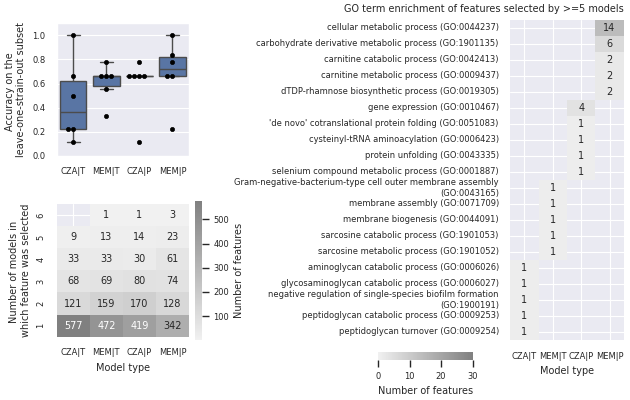

In [70]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.3, 4.0))
fig.subplots_adjust(left=0.09, bottom=0.15, top=0.95, right=0.30, hspace=0.3)

sns.boxplot(
    df_loo_acc
    .assign(mic_omics = lambda x: x.mic + "|" + x.omics), 
    x="mic_omics", 
    y="accuracy_test",
    order=("CZA|T", "MEM|T", "CZA|P", "MEM|P"),
    showfliers=False,
    ax=ax1
)
sns.swarmplot(
    df_loo_acc
    .assign(mic_omics = lambda x: x.mic + "|" + x.omics), 
    x="mic_omics",
    y="accuracy_test",
    color="black",
    linewidth=0.5,
    size=3,
    # color="black",
    ax=ax1
)
ax1.set(
    xlabel="", 
    ylabel="Accuracy on the \nleave-one-strain-out subset", 
    ylim=[0, 1.1], 
    box_aspect=1.0
)

# [0.31, 0.15, 0.01, 0.35]
cbar_ax2 = fig.add_axes([0.31, ax2.get_position().y0, 0.01, ax2.get_position().height])
sns.heatmap(
    df_num_genes, 
    annot=True, 
    fmt=".0f", 
    cbar_kws={'label': 'Number of features'},
    cbar_ax=cbar_ax2,
    cmap=other_cmap,
    ax=ax2
)

ax2.set(
    xlabel="Model type", 
    ylabel="Number of models in \nwhich feature was selected",
    box_aspect=1.0
)
ax2.invert_yaxis()

ax3 = fig.add_axes([0.81, 0.15, 0.18, 0.80])
cbar_ax3 = fig.add_axes([0.6, 0.1, 0.15, 0.02])
sns.heatmap(
    go_terms_selected, 
    annot=True, 
    vmin=0,
    vmax=30,
    ax=ax3, 
    cmap=other_cmap, 
    cbar_ax=cbar_ax3,
    cbar_kws=dict(orientation="horizontal", fraction=0.1, label="Number of features")
)
ax3.set(xlabel="Model type", ylabel="")
ax3.set_title("GO term enrichment of features selected by >=5 models", loc="right")

savefig(fig, "plsda_multiple_plots")

# Figure 5

- mut at least 2
- pls-da - ones sent to qun
- naive - df_counts.query("strain > 3")
- sort genes using go terms binary table

In [73]:
genes_mut = (
    df_mut2
    .groupby("gene_id", as_index=False)
    .agg(strain=pd.NamedAgg("strain", "count"))
    .query("strain > 1")
    .gene_id
    .pipe(set)
)

# genes_mut = df_mut.query("gene_id in @genes_mut").gene_id.tolist()
genes_plsda = df_plsda_with_pvals.gene_id.pipe(set)
    
genes_naive = pd.concat([
    df_counts_t.query("comparison != 'CZA vs MEM' and strain >= 5"),
    df_counts_p.query("comparison != 'CZA vs MEM' and strain >= 4"),
    df_counts_both.query("comparison != 'CZA vs MEM' and strain >= 3")
]).gene_id.pipe(set)

df_new_groups = (
    pd.read_csv("Data/Genes/chatgpt_curated.csv")
    .merge(df_uniprot.get(["gene_name", "gene_id"]), on="gene_name", how="left")
    .reindex(columns=["group", "gene_name", "gene_id"])
    .assign(group=lambda x: x.group.str.wrap(40))
)

# ampD, ampR, ampG, mexC, arnA, arnB due to Baharak's request
additional_genes = ("ampD", "ampR", "ampG", "mexC", "arnA", "arnB")

new_heatmap_genes = (
    genes_mut
    .union(genes_plsda)
    .union(genes_naive)
    .union(df_uniprot.query("gene_name in @additional_genes").gene_id)
)

Values used on lines 305-310:

In [74]:
len(genes_mut), len(genes_naive), len(genes_plsda)

(19, 17, 21)

In [76]:
new_comp_labels = {"CZA vs PAR": "cultured in CZA", "MEM vs PAR": "cultured in MEM"}
cols = list(product(
    ["cultured in CZA", "cultured in MEM"], 
    config["new_strain_labels"].values(), 
    ["t", "p"],
))

new_heatmap_data = (
    df_lfc
    .query("gene_id in @new_heatmap_genes and comparison in ('CZA vs PAR', 'MEM vs PAR')")
    .copy()
    .merge(df_new_groups, on=["gene_name", "gene_id"], how="left")
    .assign(
        strain=lambda x: x.strain.replace(config["new_strain_labels"]), 
        comparison=lambda x: x.comparison.replace(new_comp_labels)
    )
    # .get(["group", "gene_name", "comparison", "strain", "log2fc_t", "log2fc_p"])
    .rename(columns={"log2fc_t": "t", "log2fc_p": "p"})
    .pivot(index=["group", "gene_name", "gene_id"], columns=["comparison", "strain"], values=["t", "p"])
    .reorder_levels(order=[1, 2, 0], axis=1)
    .reindex(columns=cols, fill_value=np.nan)
    .reindex(index=df_new_groups)
)

new_heatmap_sources = (
    pd.concat(
        [
            pd.DataFrame(genes_plsda, columns=("gene_id", )).assign(source="PLS-DA"),
            pd.DataFrame(genes_mut, columns=("gene_id", )).assign(source="Mutations"),
            pd.DataFrame(genes_naive, columns=("gene_id", )).assign(source="Diff. analysis"),

        ], 
        ignore_index=True
    )
    .assign(val=1)
    .pivot(columns="source", values="val", index="gene_id")
    .reindex(index=new_heatmap_data.index.get_level_values(2))
)

ko_mutants = df_transposon.query("gene_name != 'WT'").gene_id.unique()

new_heatmap_followup = (
    pd.concat([
        pd.read_csv("Data/FollowUpExp/crispr_results.csv")
        .assign(source="CRISPR-Cas9")
        .get(["gene_name", "source"]).drop_duplicates(),
        
        df_uniprot
        .query("gene_id in @ko_mutants")
        .assign(source="Transposon mutant")
        .get(["gene_name", "source"]),
        
        pd.DataFrame({"gene_name": ["ampD"], "source": ["Expression vector"]}),
    ], ignore_index=True)
    .assign(val=1)
    .pivot(columns="source", values="val", index="gene_name")
    .reindex(columns=["Transposon mutant", "CRISPR-Cas9", "Expression vector"])
    .reindex(index=new_heatmap_data.index.get_level_values(1))
)

mic_reshaped = (
    df_mic
    .query("condition != 'P'")
    .melt(
        id_vars=["strain", "condition"],
        value_vars=["cza_mic", "mem_mic"],
        value_name="MIC",
    )
    .pivot(columns=["condition", "strain"], index="variable")
    .droplevel(0, axis=1)
    .reindex(columns=product(("C", "M"), config["new_strain_labels"].values()), fill_value=np.nan)
    .rename(index={"cza_mic": "CZA MIC", "mem_mic": "MEM MIC"})
)

mut_reshaped = (
    df_mut2
    .query("type in ('snp', 'del')")
    .replace({"condition": {"CZA": "cultured in CZA", "MEM": "cultured in MEM"}})
    .pipe(get_mut_idxs, new_heatmap_data.index.get_level_values(1), new_heatmap_data.columns, add_cols=["synonymous"])
    .replace({"synonymous": {0: " (non-synonymous)", 1: " (synonymous)"}})
    .assign(type=lambda data: data.apply(lambda x: x.type + x.synonymous if x.type == "snp" else x.type, axis=1))
    .assign(duplicated=lambda x: x.duplicated(subset=["gene_name", "strain", "condition"], keep=False))
    .query("~(duplicated == True and type == 'snp (synonymous)')")
    .drop(columns=["duplicated", "synonymous"])
    .rename(columns={"type": "Mutation type"})
)

new_heatmap_data

comparison                                                       cultured in CZA  \
strain                                                                     $1_B$   
                                                                               t   
group                                          gene_name gene_id                   
Cytochrome c and Electron Transport            ccmF      PA1480         0.448499   
Membrane Proteins and Outer Membrane\nChannels oprB      PA3186        -1.512347   
                                               oprD      PA0958         0.283124   
                                               oprE      PA0291        -1.248645   
                                               PA5022    PA5022         0.081538   
...                                                                          ...   
Transcriptional and Translational\nRegulation  nusG      PA4275        -2.071494   
                                               rtcR      PA4581        -0.321405   
                                               rpsS      PA4259        -1.070562   
                                               PA2047    PA2047         0.550294   
Type III Secretion System                      pscB      PA1715        -0.044338   

comparison                                                                  \
strain                                                                       
                                                                         p   
group                                          gene_name gene_id             
Cytochrome c and Electron Transport            ccmF      PA1480   0.052936   
Membrane Proteins and Outer Membrane\nChannels oprB      PA3186        NaN   
                                               oprD      PA0958  -2.806915   
                                               oprE      PA0291  -2.299651   
                                               PA5022    PA5022   0.819401   
...                                                                    ...   
Transcriptional and Translational\nRegulation  nusG      PA4275  -0.651811   
                                               rtcR      PA4581  -0.084726   
                                               rpsS      PA4259  -0.403843   
                                               PA2047    PA2047   1.104843   
Type III Secretion System                      pscB      PA1715        NaN   

comparison                                                                  \
strain                                                               $2_C$   
                                                                         t   
group                                          gene_name gene_id             
Cytochrome c and Electron Transport            ccmF      PA1480   0.104580   
Membrane Proteins and Outer Membrane\nChannels oprB      PA3186  -1.487350   
                                               oprD      PA0958  -0.041248   
                                               oprE      PA0291   0.059034   
                                               PA5022    PA5022  -0.016910   
...                                                                    ...   
Transcriptional and Translational\nRegulation  nusG      PA4275   1.232047   
                                               rtcR      PA4581   0.236675   
                                               rpsS      PA4259   0.830944   
                                               PA2047    PA2047   0.000000   
Type III Secretion System                      pscB      PA1715   1.496856   

comparison                                                                  \
strain                                                                       
                                                                         p   
group                                          gene_name gene_id             
Cytochrome c and Electron Transport            ccmF      PA1480   0.408380   
Membran

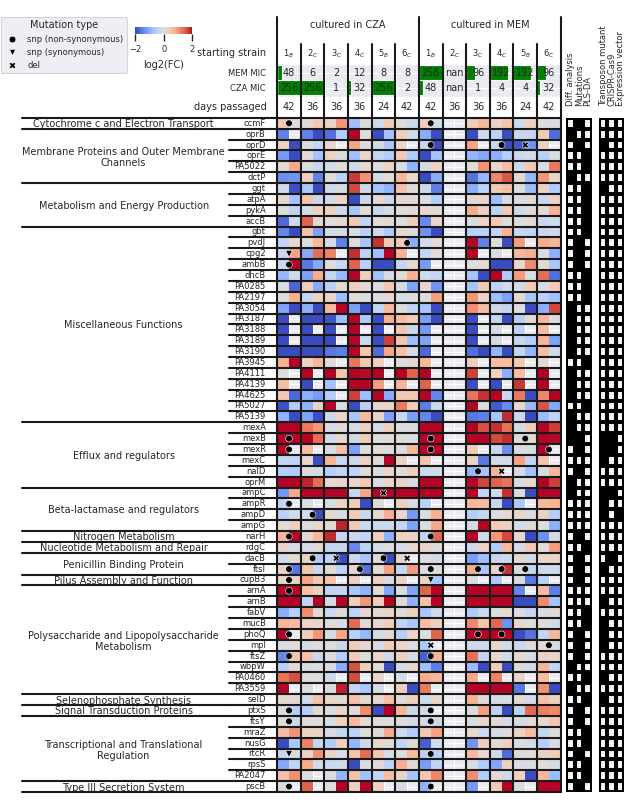

In [78]:
fig, (ax_mic, ax) = plt.subplots(2, figsize=(6.3, 8), height_ratios=(3, new_heatmap_data.shape[0]))
fig.subplots_adjust(left=0.44, right=0.89, bottom=0.01, top=0.92, hspace=0.06)
cbar_ax = ax.inset_axes([-0.5, 1.125, 0.2, 0.01])

plot_heatmap(
    fig, 
    new_heatmap_data.droplevel(2), 
    mic_reshaped, 
    mut_reshaped, 
    mut_kwargs={
        "style_order": ["snp (non-synonymous)", "snp (synonymous)", "del"],
        "markers": ["o", "v", "X"]
    },
    mut_legend_kwargs=dict(loc="lower left", bbox_to_anchor=(-0.99, 1.06)),
    x_label_kwargs=dict(pad=37, text_pos=-8.5, line_pos=(1.11, 1.15)), 
    y_label_kwargs=dict(text_pos=-13, line_pos=(0.17, 0.9)),
    cbar=True,
    cbar_ax=cbar_ax,
    cbar_kws=dict(orientation="horizontal", label="log2(FC)")
)
ax.text(-0.9, -6, "starting strain", ha="right", va="center")
ax.text(-0.9, -1., "days passaged", ha="right", va="center")
days_passaged = [42, 36, 36, 36, 24, 42] * 2
for idx, val in enumerate(days_passaged):
    ax.text(2*idx + 1, -1., val, va="center", ha="center")
ax_mic.tick_params(pad=3.2)

add_heatmap_kwargs = dict(
    cmap="gray",
    cbar=False,
    linecolor="black",
    linewidths=1.5
)

ax_metadata = ax.inset_axes([1.02, 0.0, 0.09, 1.0])
sns.heatmap(
    new_heatmap_sources, 
    ax=ax_metadata,
    **add_heatmap_kwargs
)
ax_metadata.tick_params(labeltop=True, labelbottom=False, labelleft=False, left=False, rotation=90)
ax_metadata.set_xticks(ticks=[0.5, 1.5, 2.5], labels=new_heatmap_sources.columns)
ax_metadata.set(ylabel="")

ax_crispr = ax.inset_axes([1.135, 0.0, 0.09, 1.0])
sns.heatmap(
    new_heatmap_followup, 
    ax=ax_crispr,
    **add_heatmap_kwargs
)
ax_crispr.tick_params(labeltop=True, labelbottom=False, labelleft=False, left=False, rotation=90)
ax_crispr.set_xticks(ticks=[0.5, 1.5, 2.5], labels=new_heatmap_followup.columns)
ax_crispr.set(ylabel="")

savefig(fig, "selected_genes_heatmap")

# SI Figures

## SF1 - MIC plots without strains with high MIC values

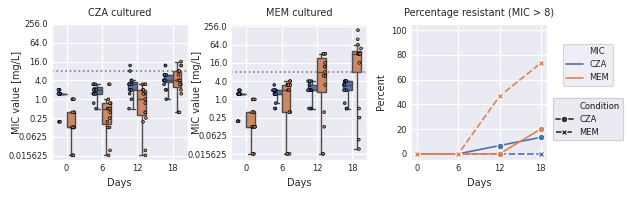

In [80]:
yticks = 2.0**np.arange(-6, 10, 2)
ignore_strains = ("095", "804", "816")  # Strains with high inital MIC
fig = df_mic_time.query("~Strain.str.startswith(@ignore_strains)").pipe(plot_all_mic, yticks=yticks.tolist())
savefig(fig, "si_mic_over_time")

## SF2 - Mutations heatmaps

In [81]:
df_mut_num = (
    df_cross_mut
    .groupby(["condition", "strain", "ref_strain"], as_index=False)
    .agg(num_mutations=pd.NamedAgg("POS", "count"))
    .pivot(index=["condition", "ref_strain"], columns="strain", values="num_mutations")
    .reset_index()
    .sort_values(["condition", "ref_strain"], ascending=[False, False])
)

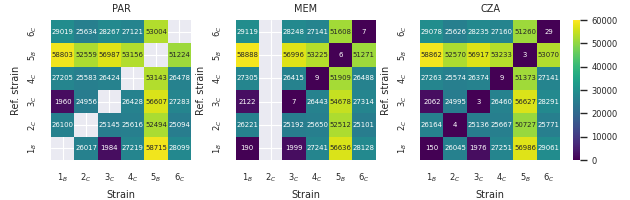

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(6.3, 2))
fig.subplots_adjust(left=0.07, right=0.9, hspace=0.4, bottom=0.2, top=0.9)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.7])

heatmap_opts = dict(
    cmap="viridis", 
    vmin=0, 
    vmax=60000,  # 2500, 
    annot=True, 
    fmt=".0f", 
    annot_kws={"fontsize": 5}, 
)

for ax, cond in zip(axs, ("PAR", "MEM", "CZA")):
    sns.heatmap(
        df_mut_num
        .query("condition == @cond")
        .drop(columns="condition")
        .set_index("ref_strain"),
        **heatmap_opts,
        ax=ax,
        cbar=False if cond != "CZA" else True,
        cbar_ax=cbar_ax
    )
    ax.set(title=cond, xlabel="Strain", ylabel="Ref. strain")

for ax in axs:
    ax.set_box_aspect(1.0)

savefig(fig, "si_num_mutations_per_condition")

## SF3 -  Vulcano plot for transcriptomics

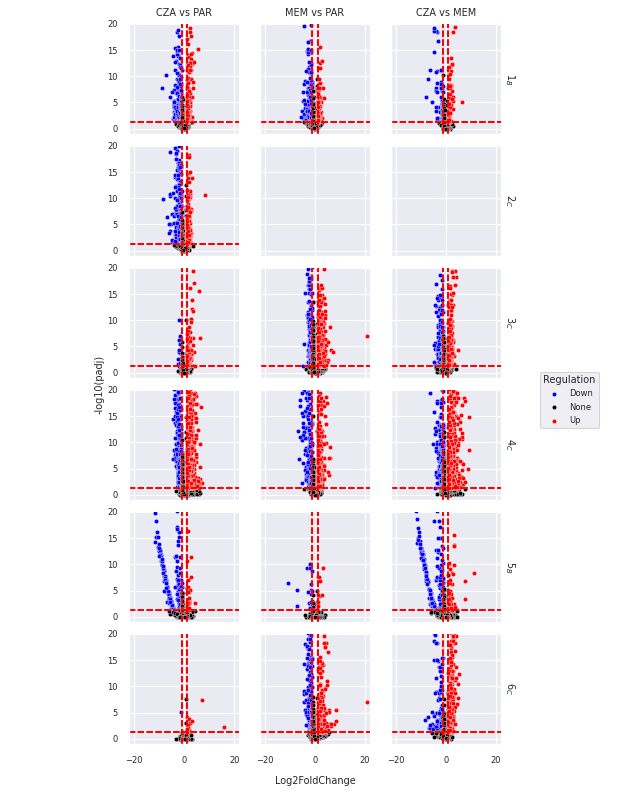

In [83]:
g = (
    sns.FacetGrid(
        df_t_lfc,
        col="comparison",
        row="strain",
        row_order=config["new_strain_labels"].values(),
        hue="regulation",
        hue_order=("Down", "None", "Up"),
        palette=("blue", "black", "red"),
        aspect=1.0,
        height=1.5,
        margin_titles=True,
    )
    .map_dataframe(
        sns.scatterplot,
        y="log_padj",
        x="log2fc",
        s=10,
    )
    .set_titles(col_template="{col_name}", row_template="{row_name}")
    .add_legend(title="Regulation", frameon=True, loc="center left", bbox_to_anchor=(0.85, 0.5))
    .set(ylim=(-1, 20), xlim=(-22, 22))
    .set_axis_labels(x_var="", y_var="")
    .refline(x=1, color="red")
    .refline(x=-1, color="red")
    .refline(y=-np.log10(0.05), color="red")
    .pipe(set_box_aspect)
)

g.figure.text(0.5, 0.02, "Log2FoldChange", ha="center")
g.figure.text(0.15, 0.52, "-log10(padj)", rotation=90, va="center")
g.figure.set_size_inches(6.3, 8)
g.figure.subplots_adjust(left=0.2, bottom=0.07, right=0.8)
savefig(g, "si_diff_expr_vulcano_plots")

## SF4 -  Vulcano plot for proteomics

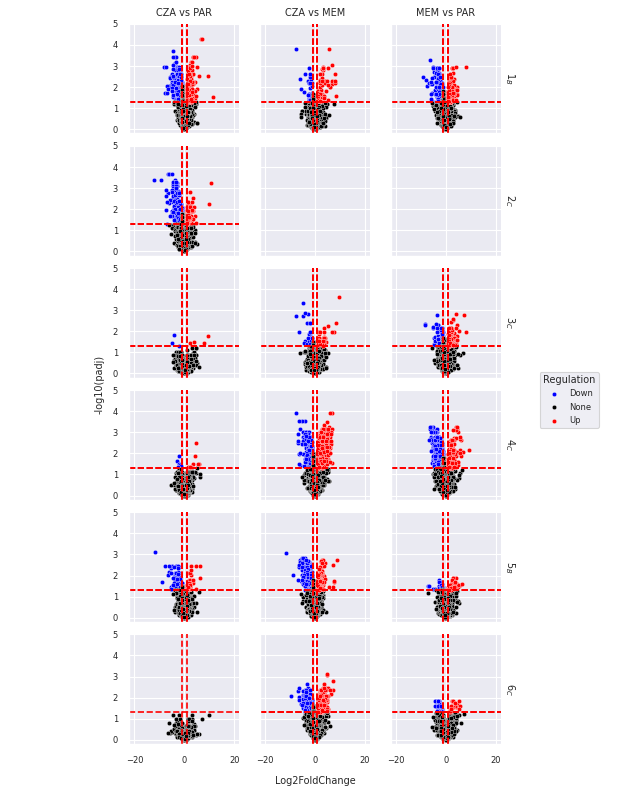

In [84]:
g = (
    sns.FacetGrid(
        df_p_lfc,
        col="comparison",
        row="strain",
        row_order=config["new_strain_labels"].values(),
        hue="regulation",
        hue_order=("Down", "None", "Up"),
        palette=("blue", "black", "red"),
        aspect=1.0,
        height=1.5,
        margin_titles=True,
    )
    .map_dataframe(
        sns.scatterplot,
        y="log_padj",
        x="log2fc",
        s=10,
    )
    .set_titles(col_template="{col_name}", row_template="{row_name}")
    .add_legend(title="Regulation", frameon=True, loc="center left", bbox_to_anchor=(0.85, 0.5))
    .set(ylim=(-0.2, 5), xlim=(-22, 22))
    .set_axis_labels(x_var="", y_var="")
    .refline(x=1, color="red")
    .refline(x=-1, color="red")
    .refline(y=-np.log10(0.05), color="red")
    .pipe(set_box_aspect)
)

g.figure.text(0.5, 0.02, "Log2FoldChange", ha="center")
g.figure.text(0.15, 0.52, "-log10(padj)", rotation=90, va="center")
g.figure.set_size_inches(6.3, 8)
g.figure.subplots_adjust(left=0.2, bottom=0.07, right=0.8)
savefig(g, "si_diff_abun_vulcano_plots")

## SF5 - PLS-DA Boxplots for CZA

In [85]:
def get_stars(pvalue):
    if pvalue < 0.01:
        return "**"
    elif pvalue < 0.05:
        return "*"
    
def add_stat_annot(ax, gene_id, subset, padj, pos_y=0.95):
    # y, h = (1+shift_y)*y, 0.02*y
    # print(pos_y)
    y, h = pos_y, 0.02
    trans = ax.get_xaxis_transform()
    
    if subset == "cza":
        col, pos_x = sns.color_palette()[0], 1/3
    elif subset == "mem":
        col, pos_x = sns.color_palette()[1], 0
    else:
        col, pos_x = "k", 0
        
    x1, x2 = 0-pos_x, 1-pos_x
        
    # print([x1, x1, x2, x2], [y, y+h, y+h, y])
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col, transform=trans)
    ax.text((x1+x2)*.5, y+h, get_stars(padj), ha='center', va='bottom', color=col, transform=trans)

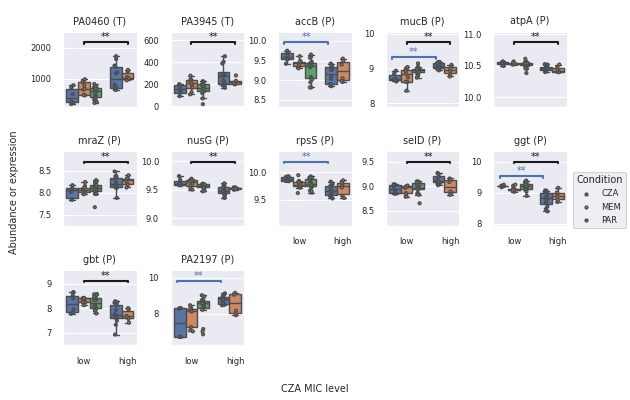

In [86]:
mic = "CZA"
df_plsda_subset = df_plsda_with_pvals.query("mic == @mic")
t_subset = df_plsda_subset.query("omics == 'T'").gene_id
p_subset = df_plsda_subset.query("omics == 'P'").gene_id
df_vals_subset = (
    pd.concat([
        df_t_long.query("gene_id in @t_subset").assign(omics="T"),
        df_p_long.query("gene_id in @p_subset").assign(omics="P")
    ])
    .assign(gene_name_omics=lambda x: x.gene_name + " (" + x.omics + ")")
)

plt_opts = dict(
    x=f"{mic.lower()}_mic_level", 
    y="value", 
    hue="condition", 
    order=["low", "high"],
    hue_order=["CZA", "MEM", "PAR"], 
    palette=sns.color_palette("deep", 3)
)

g = (
    sns.FacetGrid(
        # df_plsda_boxplots.query("mic == @mic"), 
        df_vals_subset,
        col="gene_name_omics", 
        col_wrap=5, 
        sharey=False, 
        height=1.5
    )
    .map_dataframe(sns.boxplot, **plt_opts, fliersize=0)
    .map_dataframe(sns.stripplot, **plt_opts, linewidth=1, size=2, dodge=True)
    .add_legend(frameon=True, title="Condition")
    .set_titles(col_template="{col_name}", row_template="{row_name}")
    # .set_axis_labels(x_var=f"{mic} MIC level", y_var=y_val)
    .set_axis_labels(x_var="", y_var="")
    # .set(ylim=ylim)
    .pipe(set_box_aspect)
)

ylim_ratio = 2
for gene_id, subset in df_plsda_subset.groupby("gene_id"):
    ax_id = df_vals_subset.gene_id.unique().tolist().index(gene_id)
    y0, y1 = g.axes[ax_id].get_ylim()
    num_annot = len(subset)
    y0_bracket = 1.0 - 0.2*num_annot
    g.axes[ax_id].set_ylim(0.95*y0, ylim_ratio*0.2*num_annot*max(1, (y1-y0))+y1)
    for i, (idx, row) in enumerate(subset.iterrows()):
        add_stat_annot(g.axes[ax_id], gene_id, row.condition.lower(), row.padj, pos_y=y0_bracket+0.05+(i*0.2))

g.figure.set_size_inches(6.3, 4)
g.figure.subplots_adjust(left=0.1, right=0.9, top=0.95, hspace=0.2)
g.figure.text(0.5, 0.02, f"{mic.upper()} MIC level", ha="center")
g.figure.text(0.015, 0.52, "Abundance or expression", rotation=90, va="center")
savefig(g, "si_plsda_boxplots_cza")

## SF6 - PLS-DA Boxplots for MEM

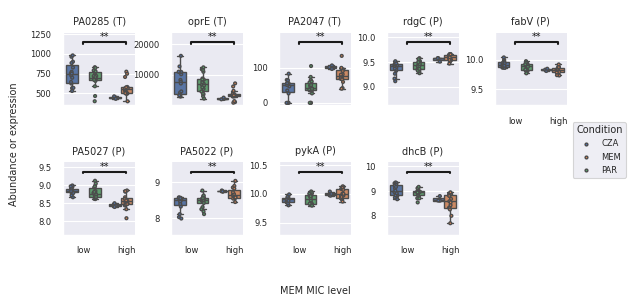

In [87]:
mic = "MEM"
df_plsda_subset = df_plsda_with_pvals.query("mic == @mic")
t_subset = df_plsda_subset.query("omics == 'T'").gene_id
p_subset = df_plsda_subset.query("omics == 'P'").gene_id
df_vals_subset = (
    pd.concat([
        df_t_long.query("gene_id in @t_subset").assign(omics="T"),
        df_p_long.query("gene_id in @p_subset").assign(omics="P")
    ])
    .assign(gene_name_omics=lambda x: x.gene_name + " (" + x.omics + ")")
)

plt_opts = dict(
    x=f"{mic.lower()}_mic_level", 
    y="value", 
    hue="condition", 
    order=["low", "high"],
    hue_order=["CZA", "MEM", "PAR"], 
    palette=sns.color_palette("deep", 3)
)

g = (
    sns.FacetGrid(
        # df_plsda_boxplots.query("mic == @mic"),
        df_vals_subset,
        col="gene_name_omics", 
        col_wrap=5, 
        sharey=False, 
        height=1.5
    )
    .map_dataframe(sns.boxplot, **plt_opts, fliersize=0)
    .map_dataframe(sns.stripplot, **plt_opts, linewidth=1, size=2, dodge=True)
    .add_legend(frameon=True, title="Condition")
    .set_titles(col_template="{col_name}", row_template="{row_name}")
    # .set_axis_labels(x_var=f"{mic} MIC level", y_var=y_val)
    .set_axis_labels(x_var="", y_var="")
    # .set(ylim=ylim)
    .pipe(set_box_aspect)
)

ylim_ratio = 2
for gene_id, subset in df_plsda_subset.groupby("gene_id"):
    ax_id = df_vals_subset.gene_id.unique().tolist().index(gene_id)
    y0, y1 = g.axes[ax_id].get_ylim()
    num_annot = len(subset)
    y0_bracket = 1.0 - 0.2*num_annot
    g.axes[ax_id].set_ylim(0.95*y0, ylim_ratio*0.2*num_annot*max(1, (y1-y0))+y1)
    for i, (idx, row) in enumerate(subset.iterrows()):
        add_stat_annot(g.axes[ax_id], gene_id, row.condition.lower(), row.padj, pos_y=y0_bracket+0.05+(i*0.2))

g.figure.set_size_inches(6.3, 3)
g.figure.subplots_adjust(left=0.1, right=0.9, top=0.95, hspace=0.2)
g.figure.text(0.5, 0.02, f"{mic.upper()} MIC level", ha="center")
g.figure.text(0.015, 0.52, "Abundance or expression", rotation=90, va="center")
savefig(g, "si_plsda_boxplots_mem")

## SF7 - Transposon mutants

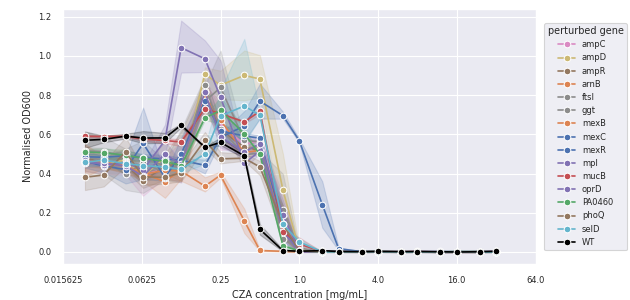

In [88]:
def get_colors(data, col="gene_id", exception="WT"):
    vals = data.get(col).unique()
    colors = sns.color_palette(n_colors=len(vals))
    return {
        key: color if key != exception else "black" 
        for key, color in zip(vals, colors)
    }

df_transposon_long = (
    df_transposon
    .melt(
        id_vars=["mutant", "gene_name", "gene_id", "mic", "conc", "log2_conc"], 
        value_vars=["norm_repl1", "norm_repl2", "norm_repl3", "norm_repl4"],
        var_name="replicate",
        value_name="norm_od"
    )
    .assign(
        replicate=lambda x: x.replicate.str[-1].astype(int),
    )
)

fig, ax = plt.subplots(figsize=(6.3, 3))
fig.subplots_adjust(left=0.1, right=0.85, bottom=0.12, top=0.97)
sns.lineplot(
    df_transposon_long
    .query(
        "(gene_id in @new_heatmap_genes or gene_name == 'WT') and "
        "mic == 'CZA'"
    )
    .query("conc not in ('MHB-Blank', 'untreated')")
    .sort_values(by="gene_name", ascending=True, key=lambda col: col.str.lower())
    .rename(columns={"gene_name": "perturbed gene"}),
    x="conc",
    y="norm_od",
    hue="perturbed gene",
    # style="gene_name",
    # markers=True,
    marker="o",
    palette=get_colors(df_transposon_long, "gene_name")
)
xticks = 2.0**np.arange(-6, 8, 2)
ax.set_xscale("log", base=2)
ax.set(
    xlabel="CZA concentration [mg/mL]", 
    ylabel="Normalised OD600", 
    xticks=xticks, 
    xticklabels=xticks
)

sns.move_legend(ax, loc="center left", bbox_to_anchor=(1.01, 0.5))
savefig(fig, "si_transposon_mic")

# SI Tables

In [89]:
strain = {"083": 1, "090": 2, "095": 3, "678": 4, "804": 5, "816": 6, "403": 7, "446": 8}
isolate = {"1": "A", "2": "B", "3": "C"}
new_labels = {
    f"{s_old}.{i_old}": f"${s_new}_{i_new}$" 
    for (s_old, s_new), (i_old, i_new) 
    in product(strain.items(), isolate.items())
}

def move_col(data, col, idx=0):
    new_data = data.copy()
    vals = new_data.pop(col)
    new_data.insert(idx, col, vals)
    return new_data

def move_go_cols(data):
    return (
        data
        .pipe(move_col, "list_size", 3)
        .pipe(move_col, "number_in_reference", 4)
        .pipe(move_col, "ref_size", 5)
    )

Path("Output/SITables").mkdir(exist_ok=True, parents=True)

## Supplementary Table 1 -  clinical isolates

In [90]:
df_si_1 = (
    df_mic
    .query("condition == 'P'")
    .get(["hospital", "collection_date", "strain", "source", "cza_mic", "mem_mic"])
    .assign(strain=lambda x: x.strain.str.strip("$").str.slice(0, 1))
    .sort_values("strain")
)
df_si_1.to_csv("Output/SITables/si_table_1.csv", index=False)
df_si_1

,hospital,collection_date,strain,source,cza_mic,mem_mic
0,KSSG,06.05.2019,1,Urine,1.50,1.000
6,KSSG,01.04.2019,2,Sputum,2.00,0.380
9,KSSG,04.04.2019,3,Urine,0.50,3.000
27,KSSG,16.07.2019,4,blood,1.50,0.125
30,KSSG,10.05.2019,5,Urine,3.00,6.000
36,KSSG,26.04.2019,6,Sputum,1.50,6.000
12,KSSG,17.05.2019,7,Sputum,0.19,0.016
18,KSSG,21.05.2019,8,Urine,1.50,0.125


## Supplementary Table 2 - evolution of resistance to MEM and CZA

In [91]:
df_si_2 = (
    df_mic_time
    .rename(columns=lambda x: x.lower())
    .rename(columns={"mic value": "mic_value"})
    .replace({
        "strain": new_labels, 
        "days": {i: f"mic_value_day_{i}" for i in (0, 6, 12, 18)}
    })
    .pivot(index=["mic", "condition", "strain"], columns="days", values="mic_value")
    .reset_index()
    .assign(fold_change=lambda x: x.get("mic_value_day_18") / x.get("mic_value_day_0"))
    .pipe(lambda x: x.merge(
        x
        .groupby(["mic", "condition"])
        .fold_change
        .median()
        .reset_index()
        .rename(columns={"fold_change": "median_fold_change"}),
        how="left",
        on=["mic", "condition"]
    ))
    .assign(
        strain=lambda x: x.strain.str.strip("$"), 
        mic_above_threshold=lambda x: (x.mic_value_day_18>8).astype(int)
    )
    .sort_values(["mic", "condition", "strain"])
    .get([
        "mic", "condition", "strain", 
        "mic_value_day_0", "mic_value_day_6", "mic_value_day_12", "mic_value_day_18",  
        "fold_change", "median_fold_change", "mic_above_threshold"
    ])
)

df_si_2.to_csv("Output/SITables/si_table_2.csv", index=False)
df_si_2

,mic,condition,strain,mic_value_day_0,mic_value_day_6,mic_value_day_12,mic_value_day_18,fold_change,median_fold_change,mic_above_threshold
0,CZA,CZA,1_A,1.500,1.500,2.000,4.000,2.666667,3.0,0
1,CZA,CZA,1_B,1.500,2.000,8.000,12.000,8.000000,3.0,1
2,CZA,CZA,1_C,1.500,1.500,1.500,2.000,1.333333,3.0,0
3,CZA,CZA,2_A,2.000,3.000,4.000,6.000,3.000000,3.0,0
4,CZA,CZA,2_B,2.000,2.000,3.000,4.000,2.000000,3.0,0
...,...,...,...,...,...,...,...,...,...,...
91,MEM,MEM,7_B,0.016,0.016,0.125,0.250,15.625000,32.0,0
92,MEM,MEM,7_C,0.016,0.016,0.016,0.023,1.437500,32.0,0
93,MEM,MEM,8_A,0.125,0.380,16.000,16.000,128.000000,32.0,1
94,MEM,MEM,8_B,0.125,0.380,0.380,0.500,4.000000,32.0,0


## Supplementary Table 3 - length of passages for the clones and final MICs to CZA and MEM

second table from Anja

In [92]:
df_si_3 = (
    df_mic
    .get(["strain", "condition", "cza_mic", "mem_mic"])
    .query("condition != 'P' and strain not in ('$7_B$', '$8_A$')")
    .merge(
        pd.read_csv("Data/Samples/omics_time.csv", dtype={"strain": str})
        .replace({"strain": new_labels}),
        on=["strain", "condition"],
        how="left"
    )
    .replace({"condition": {"C": "CZA", "M": "MEM", "P": "PAR"}})
    .drop(columns="Isolate")
    .rename(columns={"Days passaged": "days_passaged"})
    .assign(strain=lambda x: x.strain.str.strip("$"))
)

df_si_3.to_csv("Output/SITables/si_table_3.csv", index=False)
df_si_3

,strain,condition,cza_mic,mem_mic,days_passaged
0,1_B,CZA,256.00,48.0,42
1,1_B,MEM,48.00,256.0,42
2,2_C,CZA,256.00,6.0,36
3,3_C,CZA,0.75,2.0,36
4,3_C,MEM,0.75,96.0,36
5,4_C,CZA,32.00,12.0,36
6,4_C,MEM,4.00,192.0,36
7,5_B,CZA,256.00,8.0,24
8,5_B,MEM,4.00,192.0,24
9,6_C,CZA,2.00,8.0,30


## Supplementary Table 4 - trek panels

In [93]:
conds = {"C": "CZA", "M": "MEM", "P": "PAR"}
new_labels2 = {
    f"{strain}_{cond}": f"{new_strain.strip('$')}_{new_cond}" 
    for (strain, new_strain), (cond, new_cond) 
    in product(new_labels.items(), conds.items())
}

df_si_4 = (
    pd.read_csv("Data/Samples/trek_panel_long.csv")
    .pipe(lambda x:
        pd.concat([
            x
            .pivot(
                columns="strain", 
                index=["antibiotic", "susceptibility_threshold", "resistance_threshold"], 
                values="mic_value"
            )
            .reset_index(),
            
            pd.DataFrame({
                "antibiotic": ["Total"], 
                **x.groupby("strain").resistant.sum()
            })
        ])
    )
    .rename(columns=new_labels2)
    .drop(columns="2_C_MEM")
)

df_si_4.to_csv("Output/SITables/si_table_4.csv")
df_si_4

,antibiotic,susceptibility_threshold,resistance_threshold,1_B_CZA,1_B_MEM,1_B_PAR,2_C_CZA,2_C_PAR,3_C_CZA,3_C_MEM,3_C_PAR,4_C_CZA,4_C_MEM,4_C_PAR,5_B_CZA,5_B_MEM,5_B_PAR,6_C_CZA,6_C_MEM,6_C_PAR
0,Amikacin,16,16,≤4 (S),≤4 (S),8 (S),≤4 (S),≤4 (S),≤4 (S),≤4 (S),≤4 (S),≤4 (S),≤4 (S),≤4 (S),≤4 (S),16 (S),≤4 (S),≤ 4 (S),≤ 4 (S),≤ 4 (S)
1,Aztreonam,0.001,16,≥16,≥16,≥16,≥16,≥16,≥16,≥16,≥16,≥16,≥16,8,≥16,≥16,≥16,≥ 16,≥ 16,≤ 2
2,Cefepime,0.001,8,≥16 (R),≥16 (R),4,≥16 (R),8,8,16 (R),8,≥16(R),16 (R),16 (R),≥16 (R),16 (R),8,16 (R),≥ 16 (R),≤ 2
3,Cefotaxime,-,-,≥32,≥32,≥32,≥32,32,≥32,≥32,≥32,≥32,≥32,32,≥32,≥32,≥32,≥ 32,32,32
4,Ceftazidime,0.001,8,≥16 (R),≥16 (R),16 (R),≥16 (R),4,≥16 (R),4,≥16 (R),≥16 (R),16 (R),2,≥16 (R),16 (R),8,≥ 16 (R),≥ 16 (R),≤2
5,Ceftazidime / avibactam constant 4,8,8,≥256/4 (R),32/4 (R),1/4 (S),≥256/4 (R),2/4 (S),0.75/4 (S),1.5/4 (S),0.5/4 (S),64/4 (R),4/4 (S),1.5/4 (S),≥256/4 (R),4/4 (S),3/4 (S),3/4 (S),≥32/4 (R),1.5/4 (S)
6,Ceftolozane / tazobactam constant 4,4,4,16/4 (R),4/4 (S),0.75/4 (S),16/4 (R),0.5/4 (S),0.5/4 (S),0.25/4 (S),0.25/4 (S),6/4 (R),1/4 (S),0.5/4 (S),≥256/4 (R),0.5/4 (S),0.5/4 (S),2/4 (S),2/4 (S),0.75/4 (S)
7,Ciprofloxacin,0.001,0.5,≤0.25,≤0.25,0.5,≤0.25,≤0.25,≤0.25,≤0.25,≤0.25,≤0.25,1 (R),≤0.25,2 (R),0.5,1 (R),≤ 0.25,≤ 0.25,≤ 0.25
8,Colistin,2,2,0.5 (S),0.5 (S),1 (S),≤0.25 (S),0.5 (S),2 (S),1 (S),2 (S),1 (S),2 (S),1 (S),2 (S),2 (S),2 (S),2 (S),1 (S),2 (S)
9,Doripenem,NaN,NaN,≥2,≥2,2,2,0.5,2,≥2,2,1,≥2,0.25,2,≥2,2,≥ 2,≥ 2,≥ 2


## Supplementary Table 5 - mutations

### 5a. All mutations

In [94]:
cols = ['strain', 'condition', 'gene_name', 'gene_id', 'locus_tag', 'pos', 'type', 'ref', 
        'alt', 'evidence', 'ftype', 'strand', 'nt_pos', 'aa_pos', 'effect', 'product']
df_si_5a = (
    df_mut2
    .get(cols)
    .assign(strain=lambda x: x.strain.str.strip("$"))
    .replace({"condition": {"C": "CZA", "M": "MEM", "P": "PAR"}})
)

df_si_5a.to_csv("Output/SITables/si_table_5a.csv", index=False)
df_si_5a

,strain,condition,gene_name,gene_id,locus_tag,pos,type,ref,alt,evidence,ftype,strand,nt_pos,aa_pos,effect,product
0,1_B,MEM,ppkA,PA0074,IAFHHIEI_00077,86891,snp,G,A,A:200 G:0,CDS,-,1992/3099,664/1032,synonymous_variant c.1992C>T p.Thr664Thr,serine/threonine protein kinase PpkA
1,1_B,MEM,None,NaN,IAFHHIEI_00097,115931,snp,A,G,G:223 A:0,CDS,+,1874/2226,625/741,missense_variant c.1874A>G p.Asn625Ser,vgrG1b
2,1_B,MEM,pcaD,PA0231,IAFHHIEI_00228,253464,snp,A,G,G:162 A:0,CDS,+,356/792,119/263,missense_variant c.356A>G p.Asn119Ser,beta-ketoadipate enol-lactone hydrolase
3,1_B,MEM,None,NaN,IAFHHIEI_00264,294262,snp,A,G,G:186 A:0,CDS,+,296/750,99/249,missense_variant c.296A>G p.Glu99Gly,hypothetical protein
4,1_B,MEM,None,NaN,IAFHHIEI_00266,298095,snp,C,T,T:192 C:0,CDS,+,94/1158,32/385,missense_variant c.94C>T p.Pro32Ser,hypothetical protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,6_C,CZA,cdrA,NaN,IGJFGDPJ_04921,5298969,snp,A,G,G:42 A:0,CDS,-,5025/6465,1675/2154,synonymous_variant c.5025T>C p.Thr1675Thr,"cyclic diguanylate-regulated TPS partner A, CdrA"
413,6_C,CZA,cdrA,NaN,IGJFGDPJ_04921,5298993,snp,A,G,G:27 A:0,CDS,-,5001/6465,1667/2154,synonymous_variant c.5001T>C p.Gly1667Gly,"cyclic diguanylate-regulated TPS partner A, CdrA"
414,6_C,CZA,None,NaN,NaN,5380821,snp,G,A,A:41 G:0,NaN,NaN,NaN,NaN,NaN,NaN
415,6_C,CZA,None,NaN,NaN,5380836,snp,T,A,A:60 T:0,NaN,NaN,NaN,NaN,NaN,NaN


### 5b. num strains per gene

In [95]:
df_si_5b = (
    df_mut2
    .assign(strain=lambda x: x.strain.str.strip("$"))
    .groupby(["condition", "gene_id"])
    .agg(
        strain=pd.NamedAgg("strain", set), 
        num_strains=pd.NamedAgg("strain", lambda x: x.nunique())
    )
    .reset_index()
    .merge(df_uniprot.get(["gene_id", "gene_name"]), on="gene_id", how="left")
    .sort_values(["num_strains", "gene_name"], ascending=[False, True])
    .replace({"condition": {"C": "CZA", "M": "MEM", "P": "PAR"}})
)

df_si_5b.to_csv("Output/SITables/si_table_5b.csv", index=False)
df_si_5b

,condition,gene_id,strain,num_strains,gene_name
31,CZA,PA3047,"{6_C, 3_C, 5_B, 2_C}",4,dacB
119,MEM,PA4418,"{1_B, 3_C, 4_C, 5_B}",4,ftsI
70,MEM,PA0958,"{1_B, 4_C, 5_B}",3,oprD
49,CZA,PA4418,"{1_B, 4_C}",2,ftsI
65,MEM,PA0426,"{1_B, 5_B}",2,mexB
...,...,...,...,...,...
57,CZA,PA4839,{4_C},1,speA
38,CZA,PA3735,{1_B},1,thrC
102,MEM,PA3159,{3_C},1,wbpA
101,MEM,PA3145,{6_C},1,wbpL


### 5c. Number of strains and conditions per gene

In [96]:
df_si_5c = (
    df_mut2
    .assign(
        strain=lambda x: x.strain.str.strip("$"),
        strain_cond=lambda x: x.strain + "__" + x.condition)
    .groupby("gene_id")
    .agg(
        strain_condition=pd.NamedAgg("strain_cond", set), 
        num_strains=pd.NamedAgg("strain_cond", lambda x: x.nunique())
    )
    .reset_index()
    .merge(df_uniprot.get(["gene_id", "gene_name"]), on="gene_id", how="left")
    .sort_values(["num_strains", "gene_name"], ascending=[False, True])
    .assign(strain_condition=lambda x: x.strain_condition.apply(", ".join))
)

df_si_5c.to_csv("Output/SITables/si_table_5c.csv", index=False)
df_si_5c

,gene_id,strain_condition,num_strains,gene_name
98,PA4418,"5_B__MEM, 1_B__MEM, 3_C__MEM, 1_B__CZA, 4_C__C...",6,ftsI
64,PA3047,"2_C__CZA, 5_B__CZA, 6_C__CZA, 3_C__CZA",4,dacB
7,PA0426,"5_B__MEM, 1_B__MEM, 1_B__CZA",3,mexB
6,PA0424,"6_C__MEM, 1_B__MEM, 1_B__CZA",3,mexR
18,PA0958,"5_B__MEM, 1_B__MEM, 4_C__MEM",3,oprD
...,...,...,...,...
114,PA4839,4_C__CZA,1,speA
78,PA3735,1_B__CZA,1,thrC
68,PA3159,3_C__MEM,1,wbpA
67,PA3145,6_C__MEM,1,wbpL


## Supplementary Table 6 - transcriptomics

all gene fold changes, pvalues and FDR

### 6a. Raw counts

In [97]:
df_si_6a = (
    pd.read_csv("Output/DESeq2/counts.csv", index_col=0)
    .transpose()
    .reset_index(names="isolate")
    .pipe(separate, "isolate", ["strain", "condition", "replicate"], sep="_", expand=True)
    .replace({
        "strain": config["new_strain_labels"],
        "condition": {"C": "CZA", "M": "MEM", "P": "PAR"}
    })
    .drop(columns="isolate")
    .pipe(lambda x: x.get(x.columns[-3:].tolist() + x.columns[:-3].tolist()))
    .assign(strain=lambda x: x.strain.str.strip("$"))
)

df_si_6a.to_csv("Output/SITables/si_table_6a.csv", index=False)
df_si_6a

gene_id,strain,condition,replicate,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,1_B,CZA,A,7484,9023,9270,24357,843,389,217,...,1139,1321,1862,1158,4321,9,514,12022,10149,1663
1,1_B,CZA,B,5941,7652,8137,21189,586,288,130,...,1057,614,1222,859,3205,5,332,9925,7597,624
2,1_B,CZA,C,6492,7713,8253,20053,430,167,93,...,1526,258,733,687,3196,9,336,10179,6399,285
3,1_B,MEM,A,6032,6942,8893,19164,666,232,107,...,1390,441,1158,944,4357,6,382,9245,7203,450
4,1_B,MEM,B,6380,7894,9875,22030,798,276,121,...,1908,521,1244,1109,5226,2,395,12576,9178,575
5,1_B,MEM,C,6079,7781,7743,18091,551,226,113,...,1588,649,1522,1113,4871,3,452,9949,7099,610
6,1_B,PAR,A,4422,3130,12662,12027,216,101,27,...,1061,55,104,38,683,0,235,6846,542,14
7,1_B,PAR,B,5891,6197,6289,18273,802,316,295,...,795,1567,1933,1335,4314,10,431,8307,7756,1715
8,1_B,PAR,C,6297,8050,7800,20581,760,304,217,...,1677,1466,2532,1329,5089,4,470,9102,7949,1196
9,2_C,CZA,A,8662,6627,9126,20524,2130,437,111,...,3509,1125,2285,1832,6733,16,612,16039,12602,1620


### 6b. Normalized counts  

In [98]:
df_si_6b = (
    df_t
    .drop(columns=["cza_mic", "mem_mic", "isolate"])
    .pipe(lambda x: x.get(x.columns[-3:].tolist() + x.columns[:-3].tolist()))
    .assign(strain=lambda x: x.strain.str.strip("$"))
    .replace({"condition": {"C": "CZA", "M": "MEM", "P": "PAR"}})
)

df_si_6b.to_csv("Output/SITables/si_table_6b.csv", index=False)
df_si_6b

,condition,replicate,replicate2,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,strain
0,CZA,A,A,5152.742434,6212.345669,6382.405447,16769.821950,580.406450,267.826938,149.404745,...,909.509989,1281.989098,797.284305,2975.013370,6.196510,353.889579,8277.160548,6987.597938,1144.977374,1_B
1,CZA,B,B,5930.388331,7638.332185,8122.465889,21151.152726,584.953301,287.485581,129.767797,...,612.903288,1219.817293,857.465675,3199.275307,4.991069,331.406990,9907.272208,7583.430424,622.885426,1_B
2,CZA,C,C,9355.420562,11114.965926,11893.143238,28897.758554,619.659711,240.658539,134.019426,...,371.795826,1056.303646,990.014468,4605.656826,12.969622,484.199216,14668.642314,9221.401136,410.704692,1_B
3,MEM,A,A,7532.616389,8669.002483,11105.364316,23931.541858,831.684767,289.716015,133.619024,...,550.710184,1446.082523,1178.844475,5440.916712,7.492656,477.032404,11544.933442,8994.933000,561.949167,1_B
4,MEM,B,B,6430.545767,7956.540484,9953.235024,22204.533426,804.322182,278.186619,121.958627,...,525.127640,1253.855632,1117.786090,5267.403163,2.015845,398.129401,12675.633789,9250.713018,579.555457,1_B
5,MEM,C,C,6642.674998,8502.492870,8460.969322,19768.487149,602.091450,246.955840,123.477920,...,709.178495,1663.127381,1216.202874,5322.663253,3.278175,493.911679,10871.520571,7757.254451,666.562222,1_B
6,PAR,A,A,39712.830833,28109.715175,113714.125735,108011.356043,1939.839769,907.054707,242.479971,...,493.940682,933.996926,341.268108,6133.845196,0.000000,2110.473823,61482.143799,4867.560903,125.730355,1_B
7,PAR,B,B,4091.756335,4304.297065,4368.198199,12692.015534,557.051193,219.486505,204.900377,...,1088.403018,1342.618400,927.261027,2996.407542,6.945775,299.362923,5769.855691,5387.143462,1191.200495,1_B
8,PAR,C,C,5525.570810,7063.815312,6844.442166,18059.674899,666.894365,266.757746,190.415891,...,1286.404130,2221.811226,1166.187646,4465.559767,3.509970,412.421515,7986.937512,6975.188561,1049.481132,1_B
9,CZA,A,A,7807.203184,5973.024186,8225.414022,18498.619043,1919.804062,393.875293,100.046127,...,1013.981018,2059.508113,1651.211756,6068.563731,14.421063,551.605674,14456.214716,11358.390040,1460.132667,2_C


### 6c. fold changes, pvalues and FDR

In [99]:
df_si_6c = (
    df_t_lfc
    .assign(strain=lambda x: x.strain.str.strip("$"))
    .pipe(move_col, "comparison")
    .pipe(move_col, "strain")
)

df_si_6c.to_csv("Output/SITables/si_table_6c.csv", index=False)
df_si_6c

,strain,comparison,gene_id,baseMean,log2fc,lfcSE,stat,pvalue,padj,prot_id,prot_name,protein_names,gene_names,gene_name,log_padj,regulation
0,1_B,CZA vs PAR,PA0001,7498.665940,-1.268988,0.452220,-2.806134,0.005014,0.029404,Q9I7C5,DNAA_PSEAE,Chromosomal replication initiator protein DnaA,dnaA PA0001,dnaA,1.531594,Down
1,1_B,CZA vs PAR,PA0002,8043.551001,-0.658447,0.414233,-1.589557,0.111935,0.289780,Q9I7C4,DPO3B_PSEAE,Beta sliding clamp (Beta clamp) (Sliding clamp...,dnaN PA0002,dnaN,0.537932,None
2,1_B,CZA vs PAR,PA0003,10159.311757,-2.242011,0.604600,-3.708258,0.000209,0.002246,Q9I7C3,RECF_PSEAE,DNA replication and repair protein RecF,recF PA0003,recF,2.648522,Down
3,1_B,CZA vs PAR,PA0004,20697.436428,-1.053569,0.455625,-2.312361,0.020758,0.088684,Q9I7C2,GYRB_PSEAE,DNA gyrase subunit B (EC 5.6.2.2),gyrB PA0004,gyrB,1.052153,None
4,1_B,CZA vs PAR,PA0005,787.681502,-0.761569,0.258885,-2.941730,0.003264,0.021050,Q9I7C1,PLSC_PSEAE,1-acyl-sn-glycerol-3-phosphate acyltransferase...,lptA PA0005,lptA,1.676744,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89003,6_C,CZA vs MEM,PA5566,9.674621,-1.024017,0.600494,-1.705291,0.088140,0.318050,Q9HT08,Q9HT08_PSEAE,Uncharacterized protein,PA5566,PA5566,0.497505,None
89004,6_C,CZA vs MEM,PA5567,597.812245,0.076037,0.343511,0.221351,0.824819,0.958123,Q9HT07,MNME_PSEAE,tRNA modification GTPase MnmE (EC 3.6.-.-),mnmE trmE PA5567,mnmE,0.018579,None
89005,6_C,CZA vs MEM,PA5568,13001.050786,0.179668,0.480886,0.373619,0.708688,0.903799,Q9HT06,YIDC_PSEAE,Membrane protein insertase YidC (Foldase YidC)...,yidC PA5568,yidC,0.043928,None
89006,6_C,CZA vs MEM,PA5569,8855.698488,0.242905,0.253601,0.957823,0.338152,0.652380,Q9HT05,RNPA_PSEAE,Ribonuclease P protein component (RNase P prot...,rnpA PA5569,rnpA,0.185499,None


## Supplementary Table 7 - proteomics

Proteomics changes

### 7a. Raw counts

In [100]:
df_si_7a = (
    pd.read_csv("Output/Proteomics/raw.csv", index_col=0)
    .transpose()
    .rename(columns=lambda x: re.sub("^(zz|sp|tr|REV).*\|(.*)\|.*", "\\2", x))
    .reset_index(names="isolate")
    .pipe(separate, "isolate", ["strain", "condition", "replicate"], sep="_", expand=True)
    .replace({
        "strain": config["new_strain_labels"],
        "condition": {"C": "CZA", "M": "MEM", "P": "PAR"}
    })
    .drop(columns="isolate")
    .pipe(lambda x: x.get(x.columns[-3:].tolist() + x.columns[:-3].tolist()))
    .assign(strain=lambda x: x.strain.str.strip("$"))
)

df_si_7a.to_csv("Output/SITables/si_table_7a.csv", index=False)
df_si_7a

protein_name,strain,condition,replicate,P11221,P11221,P72154,P72154,P77915,P77915,Q51416,...,Q9I713,Q9HWV0,Q9HWV0,Q9HX66,Q9HX66,Q9I1D7,Y-FGCZCont00112,P15275,Q9HYM7,Y-FGCZCont00486
0,1_B,CZA,A,56077000.0,1.353600e+09,9.723900e+06,1.114000e+09,30578000.0,3.280700e+09,7734600.0,...,NaN,4.727500e+08,NaN,86913000.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1_B,CZA,C,5278300.0,1.478200e+09,3.304800e+06,6.379700e+08,14061000.0,2.021100e+09,15480000.0,...,NaN,8.819800e+06,NaN,56668000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1_B,CZA,B,57773000.0,1.866000e+09,1.005700e+07,1.363600e+09,NaN,3.355900e+09,17757000.0,...,NaN,3.191700e+07,NaN,116540000.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1_B,PAR,A,NaN,2.631300e+09,2.481400e+06,1.742200e+09,67435000.0,3.587700e+09,NaN,...,NaN,1.895100e+07,NaN,189920000.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1_B,MEM,A,28348000.0,1.896400e+09,1.816500e+08,7.164900e+08,10457000.0,2.111800e+09,7432400.0,...,NaN,3.386700e+07,NaN,67306000.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1_B,MEM,C,31784000.0,2.726200e+09,1.396400e+07,1.225300e+09,19386000.0,3.866700e+09,18044000.0,...,NaN,2.217500e+07,NaN,158650000.0,NaN,NaN,NaN,NaN,NaN,NaN
6,1_B,PAR,C,7404400.0,2.954300e+09,NaN,2.026600e+09,17137000.0,5.018900e+09,NaN,...,NaN,2.182600e+07,NaN,197540000.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1_B,PAR,B,28018000.0,2.120700e+09,1.044400e+07,2.068100e+09,131580000.0,4.641400e+09,6780600.0,...,NaN,3.540800e+07,NaN,222890000.0,NaN,NaN,NaN,NaN,NaN,NaN
8,1_B,MEM,B,105990000.0,3.481300e+09,NaN,2.215700e+09,37480000.0,5.950900e+09,54360000.0,...,NaN,8.629400e+08,NaN,186050000.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2_C,CZA,C,55399000.0,1.922500e+09,8.509500e+06,1.182400e+09,10286000.0,4.114100e+09,40611000.0,...,NaN,5.924600e+09,NaN,623150000.0,NaN,NaN,NaN,NaN,NaN,NaN


### 7b. Normalized counts

In [101]:
df_si_7b = (
    df_p
    .drop(columns=["cza_mic", "mem_mic", "isolate"])
    .pipe(lambda x: x.get(x.columns[-3:].tolist() + x.columns[:-3].tolist()))
    .assign(strain=lambda x: x.strain.str.strip("$"))
    .replace({"condition": {"C": "CZA", "M": "MEM", "P": "PAR"}})
)

df_si_7b.to_csv("Output/SITables/si_table_7b.csv", index=False)
df_si_7b

,condition,replicate,replicate2,Q9I0F4,G3XCU2,G3XCV0,G3XCX3,G3XCX7,G3XCY4,G3XD24,...,Y-FGCZCont00026,Y-FGCZCont00078,Y-FGCZCont00180,Y-FGCZCont00286,Y-FGCZCont00161,Y-FGCZCont00127,Y-FGCZCont00031,Y-FGCZCont00159,Y-FGCZCont00442,strain
0,CZA,A,A,7.805838,8.096110,9.212656,8.761256,8.726641,7.977034,9.387286,...,8.120483,8.120483,9.297588,7.897938,7.897938,7.897938,7.897938,7.897938,8.328757,1_B
1,CZA,C,B,7.671489,8.073535,9.260766,8.740516,8.700005,8.035976,9.344408,...,8.369602,8.369602,9.367154,8.467027,8.467027,8.467027,8.467027,8.467027,8.138445,1_B
2,CZA,B,C,7.993573,8.102361,9.267096,8.775042,8.704330,8.036610,9.311984,...,7.860989,7.860989,9.303640,8.101739,8.101739,8.101739,8.101739,8.101739,8.302640,1_B
3,PAR,A,A,8.135957,8.127726,9.243691,8.740734,8.499950,8.084333,9.281647,...,7.726679,7.726679,9.227695,8.021527,8.021527,8.021527,8.021527,8.021527,8.261520,1_B
4,MEM,A,B,7.390585,8.111574,9.287606,8.887666,8.655292,7.773277,9.335481,...,8.264204,8.264204,9.341769,8.156041,8.156041,8.156041,8.156041,8.156041,8.241641,1_B
5,MEM,C,C,7.798491,8.156126,9.153973,8.767717,8.535058,8.224244,9.219141,...,7.591849,7.591849,9.255998,7.955402,7.955402,7.955402,7.955402,7.955402,7.135832,1_B
6,PAR,C,A,8.226427,8.128667,9.214014,8.827111,8.721578,8.250968,9.301971,...,7.036749,7.036749,9.234844,7.696198,7.696198,7.696198,7.696198,7.696198,8.424088,1_B
7,PAR,B,B,8.179814,8.121703,9.121382,8.817091,8.723151,8.309668,9.274392,...,7.856486,7.856486,9.300779,7.804088,7.804088,7.804088,7.804088,7.804088,8.211813,1_B
8,MEM,B,C,7.760998,7.951596,9.133931,8.625610,8.779102,8.060127,9.303227,...,6.468932,6.468932,9.378776,7.784516,7.784516,7.784516,7.784516,7.784516,8.302461,1_B
9,CZA,C,A,7.536685,8.048613,9.437145,8.885340,8.359686,7.497061,9.842496,...,7.370050,7.370050,9.490427,8.121216,8.121216,8.121216,8.121216,8.121216,8.310160,2_C


### 7c. fold changes, pvalues, FDR

In [102]:
df_si_7c = (
    df_p_lfc
    .assign(strain=lambda x: x.strain.str.strip("$"))
    .pipe(move_col, "comparison")
    .pipe(move_col, "strain")
)

df_si_7c.to_csv("Output/SITables/si_table_7c.csv", index=False)
df_si_7c

,strain,comparison,protein_name,log2fc,pvalue,padj,rev,prot_id,prot_name,protein_names,gene_names,gene_id,gene_name,regulation,log_padj
0,1_B,CZA vs PAR,OPRI_PSEAE,1.913039,0.162305,0.311253,REV__sp,P11221,OPRI_PSEAE,Major outer membrane lipoprotein (Outer membra...,oprI PA2853,PA2853,oprI,None,0.506887
1,1_B,CZA vs PAR,TRUB_PSEAE,1.217671,0.089554,0.211114,REV__sp,P72154,TRUB_PSEAE,tRNA pseudouridine synthase B (EC 5.4.99.25) (...,truB orp PA4742,PA4742,truB,None,0.675482
2,1_B,CZA vs PAR,HEMN_PSEAE,-0.413817,0.712288,0.816401,REV__sp,P77915,HEMN_PSEAE,Oxygen-independent coproporphyrinogen III oxid...,hemN PA1546,PA1546,hemN,None,0.088096
3,1_B,CZA vs PAR,AMIB_PSEAE,2.004844,0.047377,0.137393,REV__sp,Q51416,AMIB_PSEAE,ATP-dependent protease ATP-binding subunit-lik...,amiB PA3365,PA3365,amiB,None,0.862035
4,1_B,CZA vs PAR,PCHA_PSEAE,-1.832505,0.020545,0.080645,REV__sp,Q51508,PCHA_PSEAE,Salicylate biosynthesis isochorismate synthase...,pchA PA4231,PA4231,pchA,None,1.093423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54604,6_C,MEM vs PAR,Q9I1D7_PSEAE,-0.336049,0.514484,0.735563,REV__tr,Q9I1D7,Q9I1D7_PSEAE,Probable ATP-binding component of ABC maltose/...,PA2341,PA2341,PA2341,None,0.133380
54605,6_C,MEM vs PAR,NaN,0.471925,0.379552,0.638901,REV__zz,Y-FGCZCont00112,NaN,NaN,NaN,Y-FGCZCont00112,NaN,None,0.194567
54606,6_C,MEM vs PAR,ALGQ_PSEAE,2.485607,0.059779,0.267279,sp,P15275,ALGQ_PSEAE,Transcriptional regulatory protein AlgQ (Algin...,algQ algR2 PA5255,PA5255,algQ,None,0.573036
54607,6_C,MEM vs PAR,Q9HYM7_PSEAE,0.554927,0.611229,0.797876,tr,Q9HYM7,Q9HYM7_PSEAE,Amidohydrolase 3 domain-containing protein,PA3374,PA3374,PA3374,None,0.098064


## Supplementary Table 8 - GO terms

GO terms

### 8a. Fig 2 GO terms

In [103]:
df_si_8a = (
    go_terms_fig2
    .assign(
        strain=lambda x: x.strain.str.strip("$"),
        num_strains=lambda x: x.num_strains.fillna(0)
    )
    .rename(columns={"num_strains": "num_strains_with_significance"})
    .pipe(move_go_cols)
)

df_si_8a.to_csv("Output/SITables/si_table_8a.csv", index=False)
df_si_8a

,comparison,strain,number_in_list,list_size,number_in_reference,ref_size,fold_enrichment,fdr,expected,pValue,term,plus_minus,omics,num_strains_with_significance
0,CZA vs MEM,1_B,8,160,19,5564,14.642105,0.000050,0.546370,2.268470e-08,heme biosynthetic process (GO:0006783),+,Transcriptomics,1.0
1,CZA vs MEM,1_B,8,160,19,5564,14.642105,0.000025,0.546370,2.268470e-08,pigment biosynthetic process (GO:0046148),+,Transcriptomics,1.0
2,CZA vs MEM,1_B,8,160,21,5564,13.247619,0.000043,0.603882,5.814517e-08,porphyrin-containing compound biosynthetic pro...,+,Transcriptomics,1.0
3,CZA vs MEM,1_B,8,160,22,5564,12.645455,0.000049,0.632638,8.915361e-08,heme metabolic process (GO:0042168),+,Transcriptomics,1.0
4,CZA vs MEM,1_B,8,160,22,5564,12.645455,0.000039,0.632638,8.915361e-08,pigment metabolic process (GO:0042440),+,Transcriptomics,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68412,MEM vs PAR,6_C,1,62,162,5564,0.553963,1.000000,1.805176,1.000000e+00,organophosphate metabolic process (GO:0019637),-,Proteomics,0.0
68413,MEM vs PAR,6_C,1,62,160,5564,0.560887,1.000000,1.782890,1.000000e+00,organic acid catabolic process (GO:0016054),-,Proteomics,0.0
68414,MEM vs PAR,6_C,1,62,156,5564,0.575269,1.000000,1.738318,1.000000e+00,cellular lipid metabolic process (GO:0044255),-,Proteomics,0.0
68415,MEM vs PAR,6_C,1,62,156,5564,0.575269,1.000000,1.738318,1.000000e+00,cellular localization (GO:0051641),-,Proteomics,0.0


### 8b. Fig 3 GO terms

In [104]:
df_si_8b = go_terms_fig3.pipe(move_go_cols)

df_si_8b.to_csv("Output/SITables/si_table_8b.csv", index=False)
df_si_8b

,omics,comparison,atleast_strains,list_size,number_in_reference,ref_size,number_in_list,fold_enrichment,fdr,expected,pValue,term,plus_minus
0,Both,CZA vs MEM,1,650,15,5564,9,5.136000,0.022113,1.752336,0.000010,antibiotic biosynthetic process (GO:0017000),+
1,Both,CZA vs MEM,1,650,230,5564,49,1.823652,0.023047,26.869159,0.000021,nitrogen compound transport (GO:0071705),+
2,Both,CZA vs MEM,1,650,13,5564,8,5.267692,0.018415,1.518692,0.000025,phenazine biosynthetic process (GO:0002047),+
3,Both,CZA vs MEM,1,650,17,5564,9,4.531765,0.021599,1.985981,0.000039,antibiotic metabolic process (GO:0016999),+
4,Both,CZA vs MEM,1,650,14,5564,8,4.891429,0.023151,1.635514,0.000052,branched-chain amino acid catabolic process (G...,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80952,Transcriptomics,MEM vs PAR,5,3,9,5564,0,0.000000,1.000000,0.004853,1.000000,methionine metabolic process (GO:0006555),-
80953,Transcriptomics,MEM vs PAR,5,3,9,5564,0,0.000000,1.000000,0.004853,1.000000,potassium ion transport (GO:0006813),-
80954,Transcriptomics,MEM vs PAR,5,3,93,5564,0,0.000000,1.000000,0.050144,1.000000,negative regulation of cellular process (GO:00...,-
80955,Transcriptomics,MEM vs PAR,5,3,162,5564,0,0.000000,1.000000,0.087347,1.000000,organophosphate metabolic process (GO:0019637),-


### 8c. Figure 4 GO terms

In [105]:
df_si_8c = go_terms_fig4.pipe(move_go_cols)

df_si_8c.to_csv("Output/SITables/si_table_8c.csv", index=False)
df_si_8c

,omics,mic,number_in_list,list_size,number_in_reference,ref_size,fold_enrichment,fdr,expected,pValue,term,plus_minus
0,P,CZA,4,15,220,5564,6.744242,1.0,0.593098,0.002301,gene expression (GO:0010467),+
1,P,CZA,1,15,1,5564,370.933333,1.0,0.002696,0.002696,cysteinyl-tRNA aminoacylation (GO:0006423),+
2,P,CZA,1,15,1,5564,370.933333,1.0,0.002696,0.002696,'de novo' cotranslational protein folding (GO:...,+
3,P,CZA,1,15,1,5564,370.933333,1.0,0.002696,0.002696,selenium compound metabolic process (GO:0001887),+
4,P,CZA,1,15,1,5564,370.933333,1.0,0.002696,0.002696,tRNA seleno-modification (GO:0070329),+
...,...,...,...,...,...,...,...,...,...,...,...,...
8823,T,MEM,0,14,22,5564,0.000000,1.0,0.055356,1.000000,tRNA aminoacylation (GO:0043039),-
8824,T,MEM,0,14,22,5564,0.000000,1.0,0.055356,1.000000,nucleobase-containing compound catabolic proce...,-
8825,T,MEM,0,14,22,5564,0.000000,1.0,0.055356,1.000000,positive regulation of cellular biosynthetic p...,-
8826,T,MEM,0,14,22,5564,0.000000,1.0,0.055356,1.000000,neutral amino acid transport (GO:0015804),-


## Supplementary Table 9 - number of strains in each omics

Counts tables

In [106]:
df_counts_mut = (
    df_mut2
    .groupby(["type", "gene_id", "gene_name", "prot_id", "prot_name"], as_index=False)
    .strain
    .nunique()
    .assign(omics="Mutations")    
    .rename(columns={"type": "mutation_type"})
)

df_si_9 = (
    pd.concat(
        [df_counts_both, df_counts_t, df_counts_p, df_counts_mut]
    )
    .get(["omics", "comparison", "mutation_type", "gene_id", "gene_name", "prot_id", "prot_name", "strain"])
    .rename(columns={"strain": "num_strains"})
)

df_si_9.to_csv("Output/SITables/si_table_9.csv", index=False)
df_si_9

,omics,comparison,mutation_type,gene_id,gene_name,prot_id,prot_name,num_strains
0,Both,CZA vs MEM,NaN,PA0016,trkA,Q9I7B0,Q9I7B0_PSEAE,1
1,Both,CZA vs MEM,NaN,PA0044,exoT,Q9I788,EXOT_PSEAE,2
2,Both,CZA vs MEM,NaN,PA0045,PA0045,Q9I787,Q9I787_PSEAE,1
3,Both,CZA vs MEM,NaN,PA0054,kptA,Q9I778,KPTA_PSEAE,1
4,Both,CZA vs MEM,NaN,PA0059,osmC,Q9I773,Q9I773_PSEAE,1
...,...,...,...,...,...,...,...,...
128,Mutations,NaN,snp,PA5277,lysA,P19572,DCDA_PSEAE,1
129,Mutations,NaN,snp,PA5278,dapF,Q51564,DAPF_PSEAE,1
130,Mutations,NaN,snp,PA5322,algC,P26276,ALGC_PSEAE,1
131,Mutations,NaN,snp,PA5334,rph,P50597,RNPH_PSEAE,1


## Supplementary Table 10 - PLS-DA

### 10a. PLS-DA accuracy values

In [107]:
cols_order = ["omics", "mic", "model_type", "strain_left_out", "accuracy_train", "accuracy_test"]
df_si_10a = (
    pd.concat([
        df_full_acc.assign(model_type="full"),
        df_loo_acc
        .assign(
            model_type="leave one out",
            strain=lambda x: x.strain.str.strip("$")
        )
        .rename(columns={"strain": "strain_left_out"})
    ])
    .replace({"omics": {"P": "Proteomics", "T": "Transcriptomics"}})
    .get(cols_order)
)

df_si_10a.to_csv("Output/SITables/si_table_10a.csv", index=False)
df_si_10a

,omics,mic,model_type,strain_left_out,accuracy_train,accuracy_test
0,Proteomics,CZA,full,NaN,0.960784,NaN
1,Proteomics,MEM,full,NaN,1.000000,NaN
2,Transcriptomics,CZA,full,NaN,0.980392,NaN
3,Transcriptomics,MEM,full,NaN,0.960784,NaN
0,Proteomics,CZA,leave one out,1_B,1.000000,0.777778
1,Proteomics,CZA,leave one out,2_C,1.000000,0.666667
2,Proteomics,CZA,leave one out,3_C,0.952381,0.111111
3,Proteomics,CZA,leave one out,4_C,0.952381,0.666667
4,Proteomics,CZA,leave one out,5_B,1.000000,0.666667
5,Proteomics,CZA,leave one out,6_C,1.000000,0.666667


### 10b. PLS-DA loading values

In [108]:
df_si_10b = (
    df_loo_loadings
    .assign(
        abs_loadings=lambda x: np.absolute(x.loadings),
        in_heatmap=lambda x: x.gene_id.isin(new_heatmap_genes),
        strain=lambda x: x.strain.str.strip("$")
    )
    .groupby(["strain", "mic", "omics", "pls"], group_keys=False)
    .apply(lambda x: x.assign(rank=x.abs_loadings.rank(ascending=False)))
    .merge(
        df_top_genes_both.get(["gene_id", "mic", "omics", "num_strains"]),
        on=["gene_id", "mic", "omics"],
        how="left"
    )
    .replace({"omics": {"P": "Proteomics", "T": "Transcriptomics"}})
    .assign(num_strains=lambda x: x.num_strains.fillna(0))
    .rename(columns={
        "pls": "factor", 
        "strain": "strain_left_out", 
        "subset": "in_heatmap",
        "num_strains": "num_strains_in_top_100"
    })
)

df_si_10b.to_csv("Output/SITables/si_table_10b.csv", index=False)
df_si_10b

,gene_id,factor,loadings,omics,mic,strain_left_out,abs_loadings,in_heatmap,rank,num_strains_in_top_100
0,PA0001,1,0.016513,Proteomics,CZA,1_B,0.016513,False,1243.0,0.0
1,PA0001,1,0.008363,Transcriptomics,CZA,1_B,0.008363,False,3647.0,1.0
2,PA0001,1,-0.004592,Proteomics,MEM,1_B,0.004592,False,1676.0,0.0
3,PA0001,1,0.030535,Transcriptomics,MEM,1_B,0.030535,False,275.0,0.0
4,PA0001,1,0.014871,Proteomics,CZA,2_C,0.014871,False,1114.0,0.0
...,...,...,...,...,...,...,...,...,...,...
179659,PA5570,2,0.034482,Transcriptomics,MEM,4_C,0.034482,False,22.0,2.0
179660,PA5570,2,0.015889,Transcriptomics,CZA,5_B,0.015889,False,2131.0,0.0
179661,PA5570,2,0.022871,Transcriptomics,MEM,5_B,0.022871,False,932.0,2.0
179662,PA5570,2,0.008842,Transcriptomics,CZA,6_C,0.008842,False,3555.0,0.0


### 10c. PLS-DA top genes

In [109]:
df_si_10c = (
    df_top_genes_both
    .assign(
        strain=lambda data: 
        data.strain.apply(lambda elem: ",".join({x.strip("$") for x in elem}))
    )
    .rename(columns={"strain": "models_with_strain_left_out"})
)
df_si_10c.to_csv("Output/SITables/si_table_10c.csv", index=False)
df_si_10c

,gene_id,omics,mic,models_with_strain_left_out,loadings,num_strains,gene_name
0,PA2047,T,MEM,"4_C,2_C,1_B,3_C,5_B,6_C",0.015628,6,PA2047
1,PA5163,P,MEM,"4_C,2_C,1_B,3_C,5_B,6_C",-0.021048,6,rmlA
2,PA1097,P,MEM,"4_C,2_C,1_B,3_C,5_B,6_C",-0.020408,6,fleQ
3,PA2544,P,MEM,"4_C,2_C,1_B,3_C,5_B,6_C",-0.018947,6,PA2544
4,PA4259,P,CZA,"4_C,2_C,1_B,3_C,5_B,6_C",0.036284,6,rpsS
...,...,...,...,...,...,...,...
2895,PA5497,P,MEM,5_B,0.045333,1,nrdJa
2896,PA5500,P,CZA,2_C,-0.048619,1,znuC
2897,PA5502,P,CZA,2_C,0.053644,1,PA5502
2898,PA5505,T,CZA,6_C,-0.037753,1,PA5505


### 10d. PLS-DA GO terms

In [110]:
df_si_10d = (
    go_terms_fig4
    .query("number_in_list > 0")
    .replace({"omics": {"P": "Proteomics", "T": "Transcriptomics"}})
    .pipe(move_go_cols)
)

df_si_10d.to_csv("Output/SITables/si_table_10d.csv", index=False)
df_si_10d

,omics,mic,number_in_list,list_size,number_in_reference,ref_size,fold_enrichment,fdr,expected,pValue,term,plus_minus
0,Proteomics,CZA,4,15,220,5564,6.744242,1.0,0.593098,0.002301,gene expression (GO:0010467),+
1,Proteomics,CZA,1,15,1,5564,370.933333,1.0,0.002696,0.002696,cysteinyl-tRNA aminoacylation (GO:0006423),+
2,Proteomics,CZA,1,15,1,5564,370.933333,1.0,0.002696,0.002696,'de novo' cotranslational protein folding (GO:...,+
3,Proteomics,CZA,1,15,1,5564,370.933333,1.0,0.002696,0.002696,selenium compound metabolic process (GO:0001887),+
4,Proteomics,CZA,1,15,1,5564,370.933333,1.0,0.002696,0.002696,tRNA seleno-modification (GO:0070329),+
...,...,...,...,...,...,...,...,...,...,...,...,...
6878,Transcriptomics,MEM,1,14,462,5564,0.860235,1.0,1.162473,1.000000,transport (GO:0006810),-
7052,Transcriptomics,MEM,1,14,478,5564,0.831441,1.0,1.202732,1.000000,localization (GO:0051179),-
7282,Transcriptomics,MEM,1,14,469,5564,0.847396,1.0,1.180086,1.000000,establishment of localization (GO:0051234),-
7283,Transcriptomics,MEM,1,14,469,5564,0.847396,1.0,1.180086,1.000000,biological regulation (GO:0065007),-


## Supplementary Table 11 - normalised counts with p-values in comparisons

In [111]:
df_si_11 = (
    df_both_w_pvals
    .replace({"omics": {"P": "Proteomics", "T": "Transcriptomics"}})
    .rename(columns={"condition": "condition_subset"})
)
df_si_11.to_csv("Output/SITables/si_table_11.csv", index=False)
df_si_11

,gene_id,pvalue,padj,fold_change,condition_subset,mic,omics
0,PA0001,0.820082,0.963081,1.064670,CZA,CZA,Transcriptomics
1,PA0002,0.212885,0.598424,0.863107,CZA,CZA,Transcriptomics
2,PA0003,0.249623,0.635539,1.228822,CZA,CZA,Transcriptomics
3,PA0004,1.000000,1.000000,1.023177,CZA,CZA,Transcriptomics
4,PA0005,0.963585,1.000000,1.566299,CZA,CZA,Transcriptomics
...,...,...,...,...,...,...,...
9560,PA5564,0.227866,0.566115,0.995759,All,MEM,Proteomics
9561,PA5565,0.475585,0.768407,1.002784,All,MEM,Proteomics
9562,PA5567,0.807264,0.920319,0.997448,All,MEM,Proteomics
9563,PA5568,0.001822,0.041998,1.010956,All,MEM,Proteomics


## Supplementary Table 12 - PLS-DA top features with p-values

In [112]:
def strip_list(values, chars=None):
    chars = chars or "$"
    return {val.strip(chars) for val in values}

df_si_12 = (
    df_plsda_with_pvals
    .rename(columns={"condition": "comparison", "strain": "strain_plsda"})
    .replace({
        "comparison": {"CZA": "CZAvsCZA", "MEM": "MEMvsMEM", "All": "AllResvsAllSens"},
        "omics": {"P": "Proteomics", "T": "Transcriptomics"}
    })
    .merge(
        pd.read_csv("Data/Genes/plsda_lit_info.csv"),
        on=["gene_id", "mic", "omics"],
        how="left"
    )
    .assign(strain_plsda=lambda x: x.strain_plsda.apply(strip_list),)
)

df_si_12.to_csv("Output/SITables/si_table_12.csv", index=False)
df_si_12

,gene_id,pvalue,padj,fold_change,comparison,mic,omics,strain_plsda,loadings,num_strains,gene_name,uniprot,function,lipopolysacchiride_comment,Reported_in_published_screen (https://doi.org/10.1128/AAC.00035-09),other_links
0,PA0460,6.559682e-07,0.000699,1.865473,AllResvsAllSens,CZA,Transcriptomics,"{4_C, 1_B, 3_C, 5_B, 6_C}",0.010349,5,PA0460,https://www.uniprot.org/uniprotkb/Q9I658/entry,"DUF2780 domain-containing protein, features fo...",alginate (STRING),increased resistance,Upregulated 5 times in response to PhoQ mutati...
1,PA3945,1.177207e-05,0.005953,1.543013,AllResvsAllSens,CZA,Transcriptomics,"{4_C, 2_C, 1_B, 5_B, 6_C}",0.024963,5,PA3945,https://www.uniprot.org/uniprotkb/Q9HX71/entry,N-acetyltransferase domain-containing protein,NaN,no record,NaN
2,PA0285,2.542238e-05,0.006428,0.768391,AllResvsAllSens,MEM,Transcriptomics,"{4_C, 2_C, 3_C, 5_B, 6_C}",-0.027219,5,PA0285,NaN,NaN,NaN,NaN,NaN
3,PA0291,1.050679e-05,0.004871,0.442162,AllResvsAllSens,MEM,Transcriptomics,"{4_C, 2_C, 3_C, 5_B, 6_C}",-0.026085,5,oprE,NaN,NaN,NaN,NaN,NaN
4,PA2047,1.478622e-06,0.001371,1.905757,AllResvsAllSens,MEM,Transcriptomics,"{4_C, 2_C, 1_B, 3_C, 5_B, 6_C}",0.015628,6,PA2047,NaN,NaN,NaN,no record,NaN
5,PA0764,1.077354e-04,0.005027,1.038471,CZAvsCZA,CZA,Proteomics,"{4_C, 2_C, 3_C, 5_B, 6_C}",-0.056694,5,mucB,https://www.uniprot.org/uniprotkb/P38108/entry,Sigma factor AlgU regulatory protein MucB,regulates alginate production (literature),hypersusceptible to at least two different ant...,mucB is AlgU/T system regulating ampR regulati...
6,PA0764,1.077354e-04,0.005027,1.038471,CZAvsCZA,CZA,Proteomics,"{4_C, 2_C, 3_C, 5_B, 6_C}",-0.056694,5,mucB,https://www.uniprot.org/uniprotkb/P38108/entry,Sigma factor AlgU regulatory protein MucB,regulates alginate production (literature),hypersusceptible to at least two different ant...,mucB is AlgU/T system regulating ampR regulati...
7,PA0764,5.259641e-05,0.005919,1.019946,AllResvsAllSens,CZA,Proteomics,"{4_C, 2_C, 3_C, 5_B, 6_C}",-0.056694,5,mucB,https://www.uniprot.org/uniprotkb/P38108/entry,Sigma factor AlgU regulatory protein MucB,regulates alginate production (literature),hypersusceptible to at least two different ant...,mucB is AlgU/T system regulating ampR regulati...
8,PA0764,5.259641e-05,0.005919,1.019946,AllResvsAllSens,CZA,Proteomics,"{4_C, 2_C, 3_C, 5_B, 6_C}",-0.056694,5,mucB,https://www.uniprot.org/uniprotkb/P38108/entry,Sigma factor AlgU regulatory protein MucB,regulates alginate production (literature),hypersusceptible to at least two different ant...,mucB is AlgU/T system regulating ampR regulati...
9,PA1338,1.077354e-04,0.005027,0.954398,CZAvsCZA,CZA,Proteomics,"{4_C, 2_C, 3_C, 5_B, 6_C}",0.061559,5,ggt,https://www.uniprot.org/uniprotkb/Q9I406/entry,Glutathione hydrolase proenzyme,NaN,increased resistance,Downregulated in associated with the fusA1P443...


## Supplementary Table 13 - heatmap data

Heatmap data

In [113]:
def add_multiindex(data, iterables, **kwargs):
    data.columns = pd.MultiIndex.from_product([*iterables, data.columns])
    return data

df_si_13 = (
    new_heatmap_data
    .rename(columns=lambda x: x.strip("$"), level=1)
    .rename(columns={"t": "Transcriptomics LFC", "p": "Proteomics LFC"}, level=2)
    .join(
        new_heatmap_sources
        .fillna(0)
        .pipe(add_multiindex, [["additional_info"], ["sources"]]),
    )
    .join(
        new_heatmap_followup
        .fillna(0)
        .pipe(add_multiindex, [["additional_info"], ["follow-up"]]),
    )
)
df_si_13.to_csv("Output/SITables/si_table_13.csv")
df_si_13

cultured in CZA  \
                                                                                 1_B   
                                                                 Transcriptomics LFC   
group                                          gene_name gene_id                       
Cytochrome c and Electron Transport            ccmF      PA1480             0.448499   
Membrane Proteins and Outer Membrane\nChannels oprB      PA3186            -1.512347   
                                               oprD      PA0958             0.283124   
                                               oprE      PA0291            -1.248645   
                                               PA5022    PA5022             0.081538   
...                                                                              ...   
Transcriptional and Translational\nRegulation  nusG      PA4275            -2.071494   
                                               rtcR      PA4581            -0.321405   
                                               rpsS      PA4259            -1.070562   
                                               PA2047    PA2047             0.550294   
Type III Secretion System                      pscB      PA1715            -0.044338   

                                                                                 \
                                                                                  
                                                                 Proteomics LFC   
group                                          gene_name gene_id                  
Cytochrome c and Electron Transport            ccmF      PA1480        0.052936   
Membrane Proteins and Outer Membrane\nChannels oprB      PA3186             NaN   
                                               oprD      PA0958       -2.806915   
                                               oprE      PA0291       -2.299651   
                                               PA5022    PA5022        0.819401   
...                                                                         ...   
Transcriptional and Translational\nRegulation  nusG      PA4275       -0.651811   
                                               rtcR      PA4581       -0.084726   
                                               rpsS      PA4259       -0.403843   
                                               PA2047    PA2047        1.104843   
Type III Secretion System                      pscB      PA1715             NaN   

                                                                                      \
                                                                                 2_C   
                                                                 Transcriptomics LFC   
group                                          gene_name gene_id                       
Cytochrome c and Electron Transport            ccmF      PA1480             0.104580   
Membrane Proteins and Outer Membrane\nChannels oprB      PA3186            -1.487350   
                                               oprD      PA0958            -0.041248   
                                               oprE      PA0291             0.059034   
                                               PA5022    PA5022            -0.016910   
...                                                                              ...   
Transcriptional and Translational\nRegulation  nusG      PA4275             1.232047   
                                               rtcR      PA4581             0.236675   
                                               rpsS      PA4259             0.830944   
                                               PA2047    PA2047             0.000000   
Type III Secretion System                      pscB      PA1715             1.496856   

                                                                                 \
                                                                                  
               

## Supplementary Table 14 - genes vs GO terms

genes vs GO terms

In [114]:
df_si_14 = df_genes_vs_go_terms
df_si_14.to_csv("Output/SITables/si_table_14.csv", index=True)
df_si_14

go_terms,GO:0000003,GO:0000006,GO:0000014,GO:0000018,GO:0000027,GO:0000028,GO:0000035,GO:0000036,GO:0000041,GO:0000049,...,GO:2000245,GO:2000371,GO:2000372,GO:2000765,GO:2000766,GO:2000767,GO:2001020,GO:2001141,GO:2001313,GO:2001315
gene_stable_id,,,,,,,,,,,,,,,,,,,,,
PA0001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PA0002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PA0003,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PA0004,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PA0005,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5565,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PA5567,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PA5568,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Supplementary Table 15 - transposon mutants data

Transposon mutant MIC screen results

### 15a. Raw data

In [115]:
df_si_15a = (
    df_transposon
    .query(
        "(gene_id in @new_heatmap_genes or gene_name == 'WT') and "
        "mic == 'CZA'"
    )
)
df_si_15a.to_csv("Output/SITables/si_table_15a.csv", index=True)
df_si_15a

,mutant,mic,conc,repl1,repl2,repl3,repl4,gene_name,gene_id,exp_round,norm_repl1,norm_repl2,norm_repl3,norm_repl4,log2_conc
0,PW1776,CZA,MHB-Blank,0.088,0.087,0.086,0.087,mexR,PA0424,1,0.00100,0.00000,-0.00100,0.00000,MHB-Blank
1,PW1776,CZA,untreated,0.728,0.750,0.774,0.667,mexR,PA0424,1,0.64100,0.66300,0.68700,0.58000,untreated
2,PW1776,CZA,0.023,0.584,0.595,0.574,0.538,mexR,PA0424,1,0.49700,0.50800,0.48700,0.45100,-5.442222
3,PW1776,CZA,0.032,0.571,0.557,0.555,0.596,mexR,PA0424,1,0.48400,0.47000,0.46800,0.50900,-4.965784
4,PW1776,CZA,0.047,0.577,0.564,0.553,0.619,mexR,PA0424,1,0.49000,0.47700,0.46600,0.53200,-4.411195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,mPAO1,CZA,8,0.088,0.088,0.090,0.089,WT,WT,1,0.00075,0.00075,0.00275,0.00175,3.0
1027,mPAO1,CZA,12,0.086,0.086,0.093,0.087,WT,WT,1,-0.00125,-0.00125,0.00575,-0.00025,3.584963
1028,mPAO1,CZA,16,0.088,0.087,0.086,0.086,WT,WT,1,0.00075,-0.00025,-0.00125,-0.00125,4.0
1029,mPAO1,CZA,24,0.088,0.091,0.088,0.085,WT,WT,1,0.00075,0.00375,0.00075,-0.00225,4.584963


### 15b. MIC data

In [116]:
def get_mic(data, threshold=0.005):
    return data.query("norm_od < @threshold").conc.min()

df_si_15b = (
    df_transposon_long
    .query(
        "(gene_id in @new_heatmap_genes or gene_name == 'WT') and "
        "mic == 'CZA' and "
        "conc not in ('MHB-Blank', 'untreated')"
    )
    .groupby(["mutant", "gene_name", "gene_id", "mic", "conc"], as_index=False)
    .agg(norm_od=pd.NamedAgg("norm_od", "mean"))
    .groupby(["mutant", "gene_name", "gene_id", "mic"])
    .apply(get_mic)
    .reset_index(name="mic_value")
    .merge(
        pd.read_csv("Data/Genes/transposon_lit_info.csv"),
        on=["mutant", "gene_name", "gene_id", "mic"],
        how="outer"
    )
)

df_si_15b.to_csv("Output/SITables/si_table_15b.csv", index=True)
df_si_15b

,mutant,gene_name,gene_id,mic,mic_value,Reported_in_published_screen_PMC2687185
0,PW1776,mexR,PA0424,CZA,3.00,no record
1,PW1781,mexB,PA0426,CZA,0.75,hypersusceptible to at least two different ant...
2,PW1841,PA0460,PA0460,CZA,1.00,increased resistance
3,PW2389,mucB,PA0764,CZA,1.50,hypersusceptible to at least two different ant...
4,PW2742,oprD,PA0958,CZA,1.00,increased resistance
5,PW3132,phoQ,PA1180,CZA,1.50,no record
6,PW3431,ggt,PA1338,CZA,1.50,increased resistance
7,PW3925,selD,PA1642,CZA,1.50,no record
8,PW7021,arnB,PA3552,CZA,1.50,no record
9,PW7798,mpl,PA4020,CZA,1.00,no record


## Excel - all tables

In [117]:
df_contents = pd.DataFrame([
    ["Supplementary Table 1.", "Information about clinical isolates including the initial antibiotic resistance screening."],
    ["Supplementary Table 2.", "Evolution of resistance to MEM and CZA measured over time."],
    ["Supplementary Table 3.", "Final CZA and MEM MIC and passage length for the strains subjected to multi-omics profiling. "],
    ["Supplementary Table 4.", "Trek panel results."],
    ["Supplementary Table 5a.", "Mutations identified in the evolved strains with whole genome sequencing - List of mutations."],
    ["Supplementary Table 5b.", "Mutations identified in the evolved strains with whole genome sequencing - Number of mutations per gene and condition."],
    ["Supplementary Table 5c.", "Mutations identified in the evolved strains with whole genome sequencing - Number of mutations per gene"],
    ["Supplementary Table 6a.", "Transcriptomic changes in the evolved strains - raw gene count table"],
    ["Supplementary Table 6b.", "Transcriptomic changes in the evolved strains - Normalised gene count table."],
    ["Supplementary Table 6c.", "Transcriptomic changes in the evolved strains - Fold changes and p-values for all detected genes. "],
    ["Supplementary Table 7a.", "Proteomics changes in the evolved strains - Raw protein count table."],
    ["Supplementary Table 7b.", "Proteomics changes in the evolved strains - Normalised protein count table."],
    ["Supplementary Table 7c.", "Proteomics changes in the evolved strains - Fold changes and p-values for all detected proteins."],
    ["Supplementary Table 8a.", "Gene ontology enrichment results for differentially expressed genes and proteins - Gene ontology enrichment results for differentially expressed genes and proteins."],
    ["Supplementary Table 8b.", "Gene ontology enrichment results for differentially expressed genes and proteins - Gene ontology enrichment results for differentially expressed genes and proteins that appear in more than a given number of strains"],
    ["Supplementary Table 8c.", "Gene ontology enrichment results for differentially expressed genes and proteins - Gene ontology enrichment results for genes or proteins that appeared in top hundred features in at least five PLS-DA models."],
    ["Supplementary Table 9.", "Number of strains in which each gene/protein changed upon antibiotic treatment. "],
    ["Supplementary Table 10a.", "PLS-DA model and feature information - CZA and MEM resistance prediction accuracy for the full and leave-one-strain-out models."],
    ["Supplementary Table 10b.", "PLS-DA model and feature information - model feature importance."],
    ["Supplementary Table 10c.", "PLS-DA model and feature information - the count of models in which each gene ranked among the top 100 features based on weights."],
    ["Supplementary Table 10d.", "PLS-DA model and feature information - gene ontology enrichment results for features selected by a given number of models."],
    ["Supplementary Table 11.", "Fold change and p-values of gene expression and protein abundances between all strains grouped by resistance to CZA or MEM across conditions. "],
    ["Supplementary Table 12.", "Top genes and proteins selected from PLS-DA analysis. "],
    ["Supplementary Table 13.", "Top genes and proteins selected from mutation analysis, differential analysis, and PLS-DA. "],
    ["Supplementary Table 14.", "Matrix of genes and their associated gene ontology pathways."],
    ["Supplementary Table 15a.", "Transposon mutant MIC screening results - raw and normalised OD600 values."],
    ["Supplementary Table 15b.", "Transposon mutant MIC screening results - MIC value for each mutant."]
    
], columns=["Spreadsheet tab name", "SI table description"])
df_contents

,Spreadsheet tab name,SI table description
0,Supplementary Table 1.,Information about clinical isolates including ...
1,Supplementary Table 2.,Evolution of resistance to MEM and CZA measure...
2,Supplementary Table 3.,Final CZA and MEM MIC and passage length for t...
3,Supplementary Table 4.,Trek panel results.
4,Supplementary Table 5a.,Mutations identified in the evolved strains wi...
5,Supplementary Table 5b.,Mutations identified in the evolved strains wi...
6,Supplementary Table 5c.,Mutations identified in the evolved strains wi...
7,Supplementary Table 6a.,Transcriptomic changes in the evolved strains ...
8,Supplementary Table 6b.,Transcriptomic changes in the evolved strains ...
9,Supplementary Table 6c.,Transcriptomic changes in the evolved strains ...


In [118]:
with pd.ExcelWriter("Output/SITables/all_tables.xlsx") as writer:
    df_contents.to_excel(writer, sheet_name='Contents', index=False)
    df_si_1.to_excel(writer, sheet_name='SI table 1', index=False)
    df_si_2.to_excel(writer, sheet_name='SI table 2', index=False)
    df_si_3.to_excel(writer, sheet_name='SI table 3', index=False)
    df_si_4.to_excel(writer, sheet_name='SI table 4', index=False)
    
    df_si_5a.to_excel(writer, sheet_name='SI table 5a', index=False)
    df_si_5b.to_excel(writer, sheet_name='SI table 5b', index=False)
    df_si_5c.to_excel(writer, sheet_name='SI table 5c', index=False)
    
    df_si_6a.to_excel(writer, sheet_name='SI table 6a', index=False)
    df_si_6b.to_excel(writer, sheet_name='SI table 6b', index=False)
    df_si_6c.to_excel(writer, sheet_name='SI table 6c', index=False)
    
    df_si_7a.to_excel(writer, sheet_name='SI table 7a', index=False)
    df_si_7b.to_excel(writer, sheet_name='SI table 7b', index=False)
    df_si_7c.to_excel(writer, sheet_name='SI table 7c', index=False)
    
    df_si_8a.to_excel(writer, sheet_name='SI table 8a', index=False)
    df_si_8b.to_excel(writer, sheet_name='SI table 8b', index=False)
    df_si_8c.to_excel(writer, sheet_name='SI table 8c', index=False)
    
    df_si_9.to_excel(writer, sheet_name='SI table 9', index=False)
    
    df_si_10a.to_excel(writer, sheet_name="SI table 10a", index=False)
    df_si_10b.to_excel(writer, sheet_name="SI table 10b", index=False)
    df_si_10c.to_excel(writer, sheet_name="SI table 10c", index=False)
    df_si_10d.to_excel(writer, sheet_name="SI table 10d", index=False)
    
    df_si_11.to_excel(writer, sheet_name="SI table 11", index=False)
    df_si_12.to_excel(writer, sheet_name="SI table 12", index=False)
    df_si_13.to_excel(writer, sheet_name="SI table 13")
    
    df_si_14.to_excel(writer, sheet_name="SI table 14", index=False)
    
    df_si_15a.to_excel(writer, sheet_name="SI table 15a", index=False)
    df_si_15b.to_excel(writer, sheet_name="SI table 15b", index=False)
    